File(s) generated: data/histogram-3.pkl

Assume a "conventional WEC" shape, where successive (h-d) past the region adjacent to the target region are taller.

Do ratios from 4-dependencies: (h-d1)/radwidth1, (h-d0)/(h-d1), (h-d2)/(h-d1), radwidth1/a1, but for a wider range of non-fixed values. Furthermore it's good to have some data for more regions with this as a middle region (e.g. 4 or 5) to ensure behavior is consistent.

Check for damping: radwidth1/dist_to_e.


In [1]:
import sys
import os
sys.path.append(os.path.relpath('../../../'))
sys.path.append(os.path.relpath('../../'))

from helpers import *
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
file1 = "data/histogram-3.pkl"

hmdrs = [30]
left_ratios = [0.5, 0.95, 1.05, 1.3]
right_ratios = [0.5, 0.95, 1.05, 1.3]
rad_ratios = [0.1, 0.2]
region_counts = [3]

rho, big_nmk, nmk_max = 1023, 200, 150

def solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max, region = 1):
  prob = ConvergenceProblemI(h, d, a, heaving, NMK, m0, rho)
  mk = prob.m_k
  info = {"h" : h,
          "d" : d,
          "a" : a,
          "region" : region,
          "m0s" : [m0]}
  print(info)
  return merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))

def generate_h_d_a_m0_second(hmdr, left_ratio, right_ratio, rad_ratio, region_count):
  hmd1 = random.uniform(low = 0, high = 10)
  hmd0 = left_ratio * hmd1
  hmd2 = right_ratio * hmd1
  radwidth1 = hmd1/hmdr
  radwidth0 = radwidth1/rad_ratio - radwidth1
  radwidth2 = hmd2/random.uniform(low=1, high =10)

  radwidths = [radwidth0, radwidth1, radwidth2]
  hmds = [hmd0, hmd1, hmd2]

  for i in range(3, region_count):
    hmds.append(random.uniform(low = 1.01, high = 3) * hmds[-1])
    radwidths.append(hmds[-1]/random.uniform(low=1, high =10))

  h_min = max(hmds)
  h = random.uniform(low = 1.1 * h_min, high = 3 * h_min)
  m0 = random.uniform(low = 1/h, high = 80/h)
  d = [h-hmd for hmd in hmds]
  a = [sum(radwidths[0:i+1]) for i in range(len(d))]
  for i in range(len(d)):
    assert d[i] > 0
    inner = 0 if i == 0 else a[i-1]
    assert a[i] > inner
  return h, d, a, m0

all_prob_sets = []
for region_count in region_counts:
  heaving, NMK = [region == 1 for region in range(region_count)], [big_nmk] * (region_count + 1)
  for hmdr in hmdrs:
    for left_ratio in left_ratios:
      for right_ratio in right_ratios:
        for rad_ratio in rad_ratios:
          prob_set = []
          for i in range(50):
            h, d, a, m0 = generate_h_d_a_m0_second(hmdr, left_ratio, right_ratio, rad_ratio, region_count)
            prob_set.append(solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max))
          all_prob_sets.append(prob_set)
          update_data_file(all_prob_sets, file1)
          print("Finished a set.", region_count, hmdr, right_ratio)


In [3]:
hist_prob_sets = open_pkl_file(file1)
for subset in hist_prob_sets:
  generate_convergence_data(subset, [0.01, 0.005])
  generate_log_data(subset)

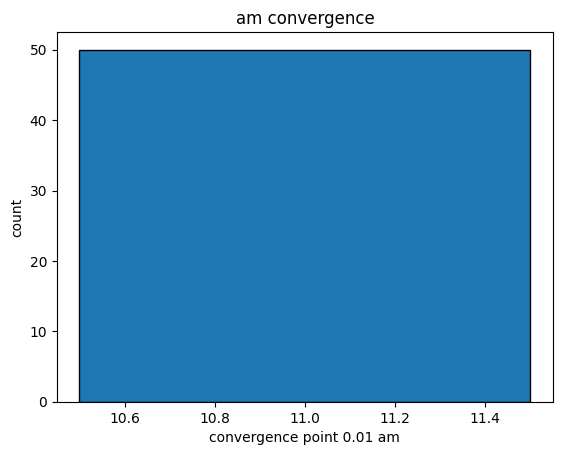

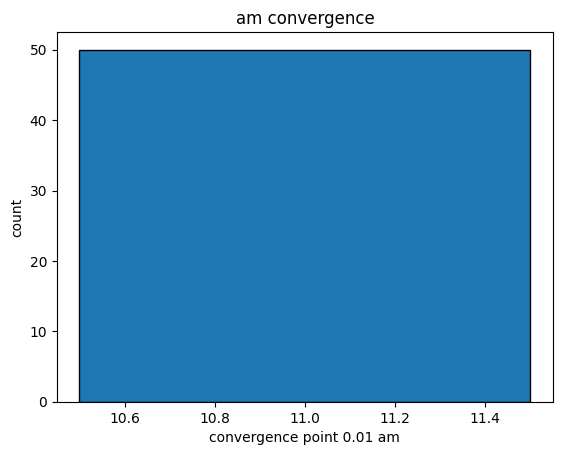

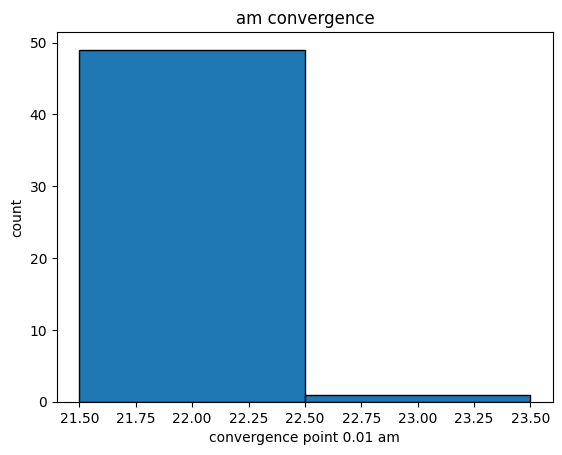

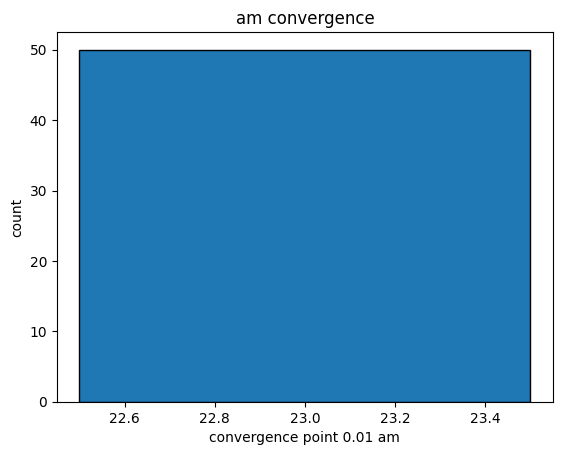

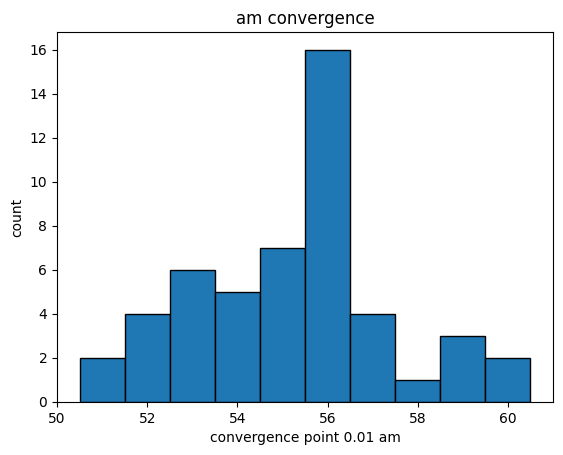

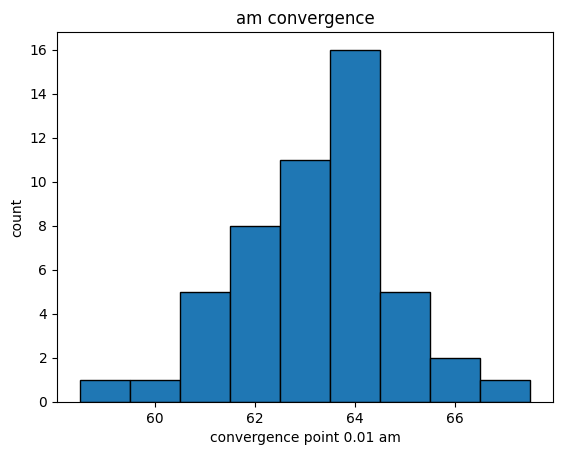

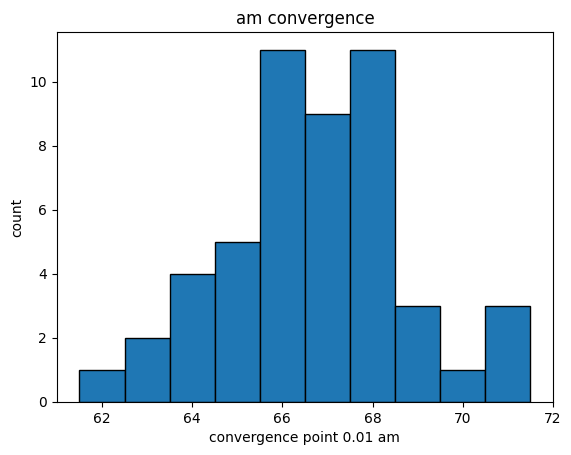

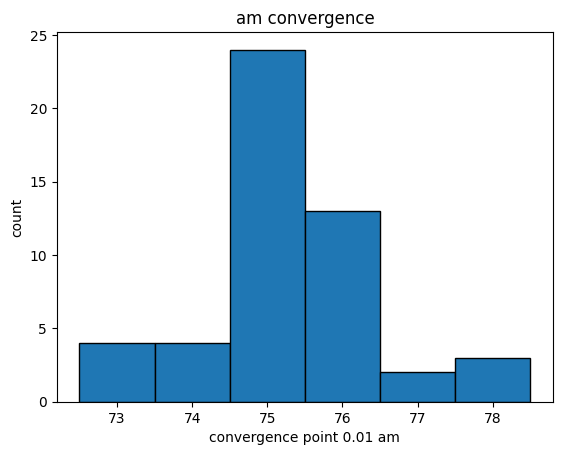

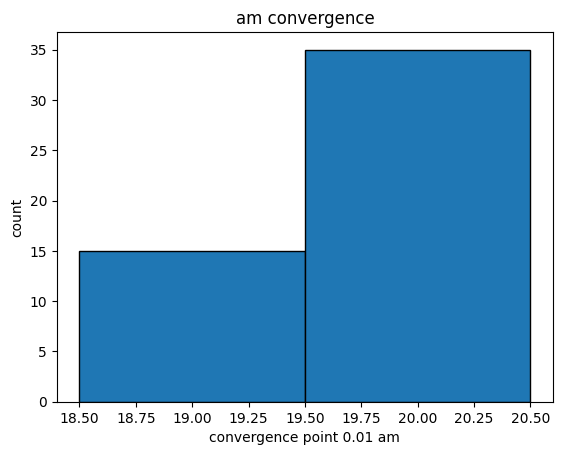

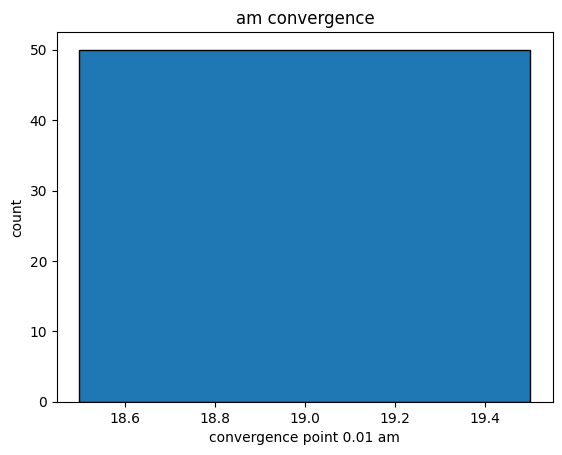

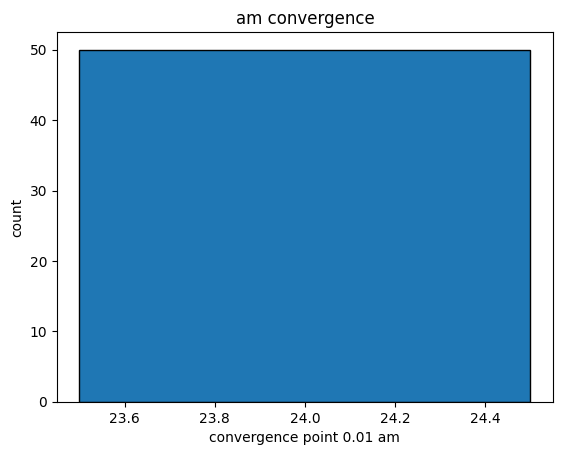

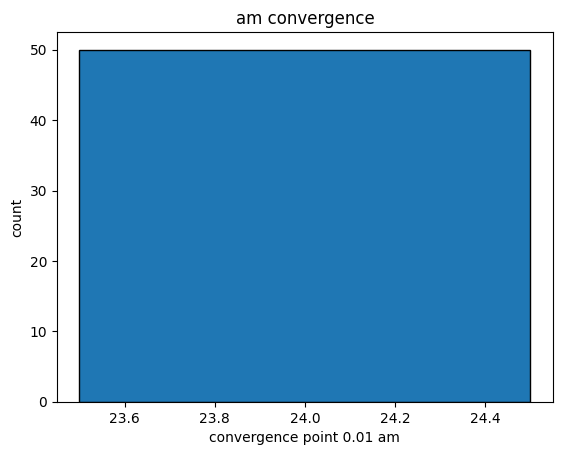

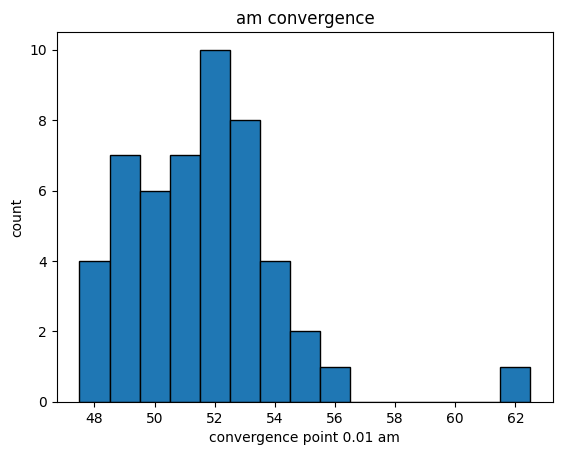

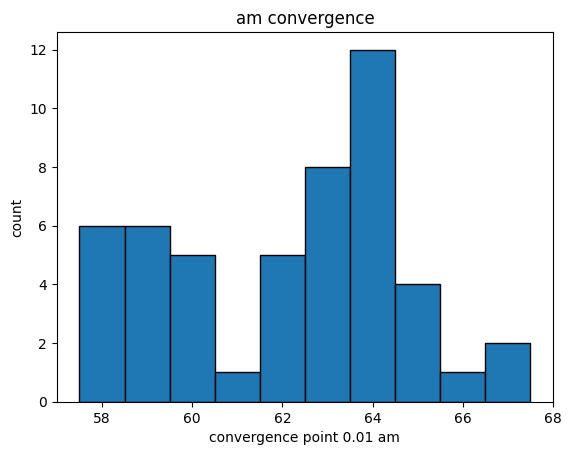

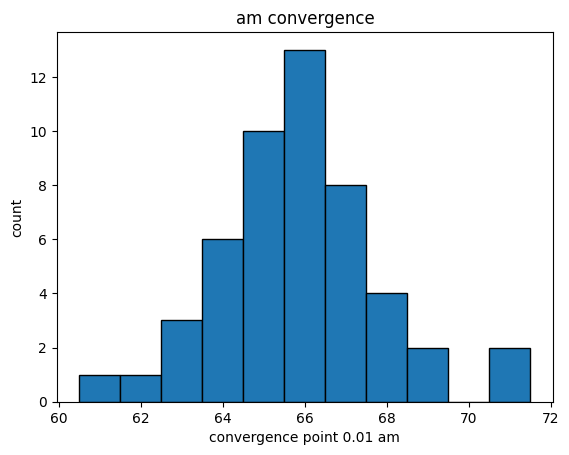

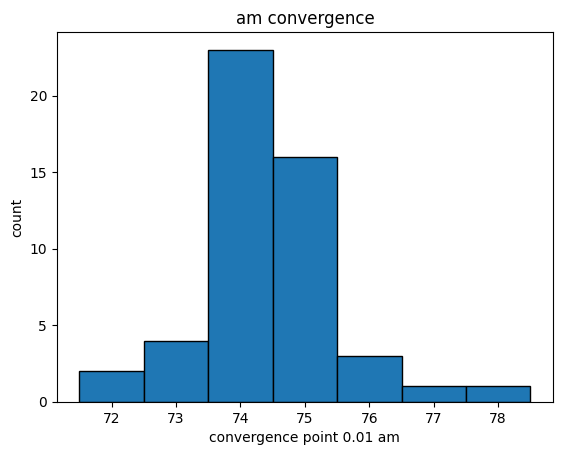

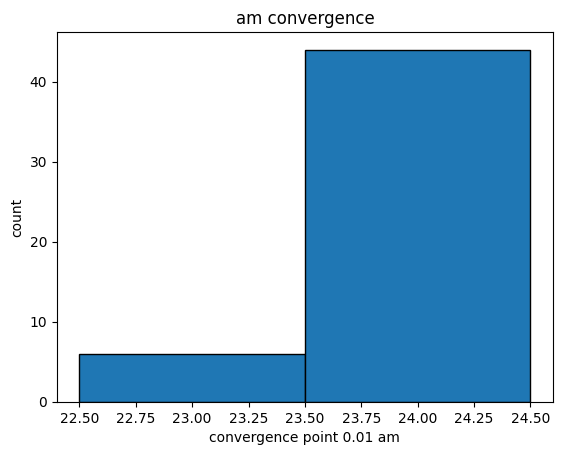

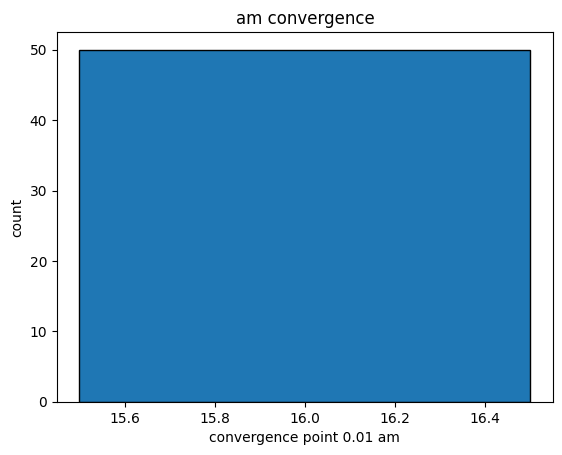

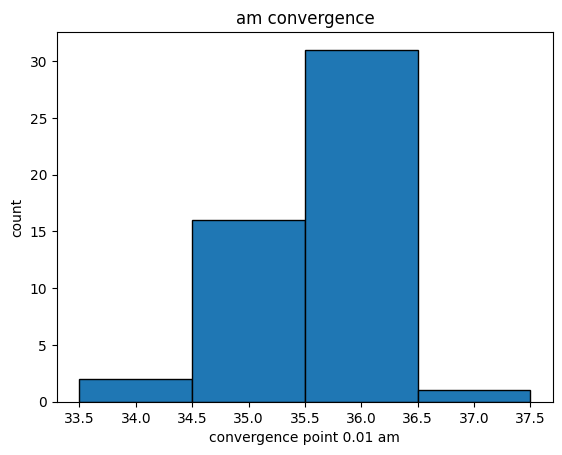

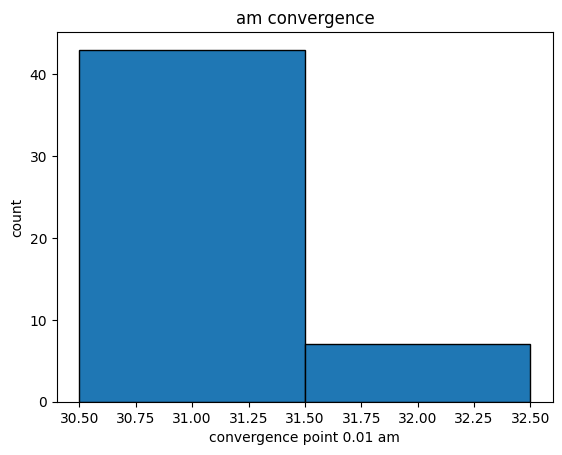

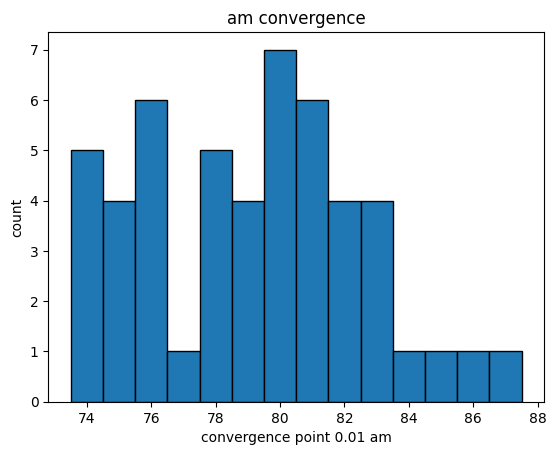

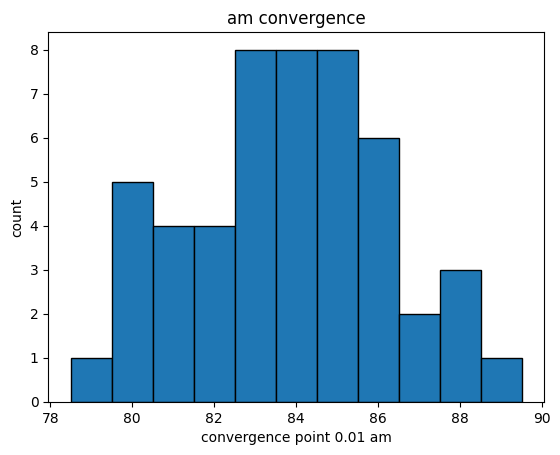

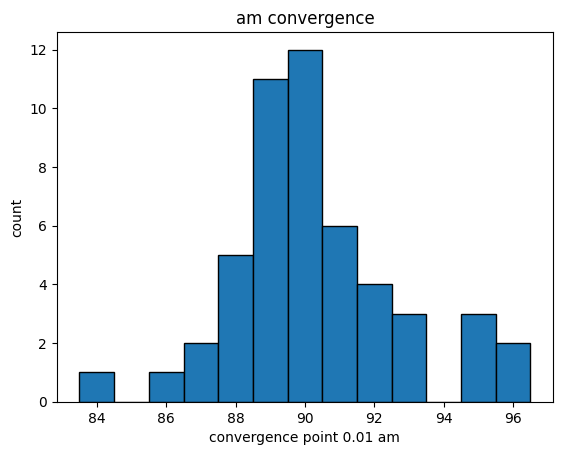

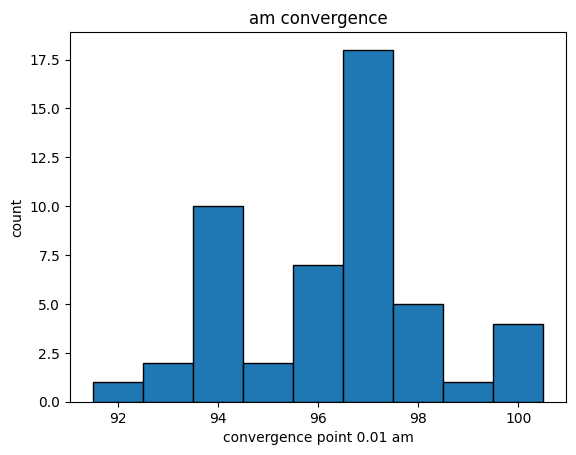

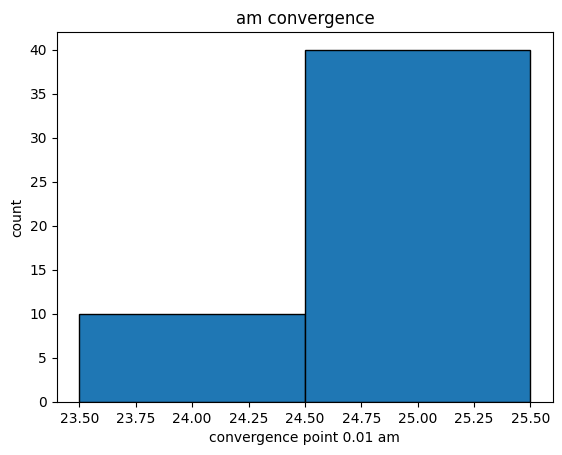

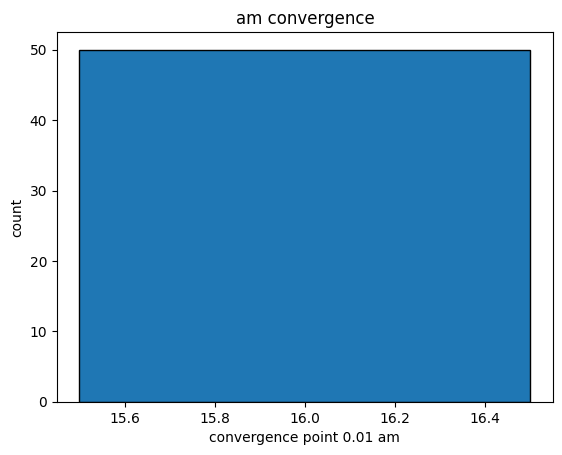

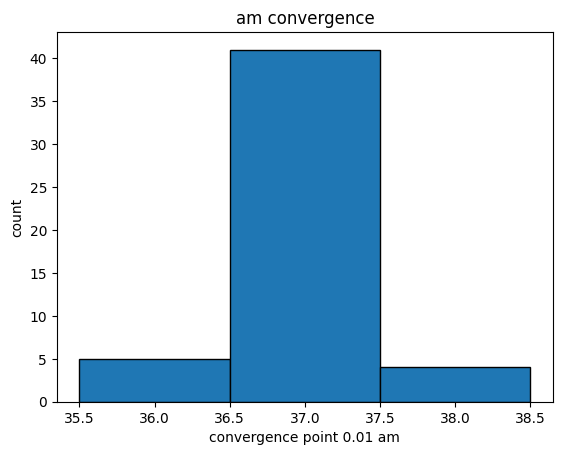

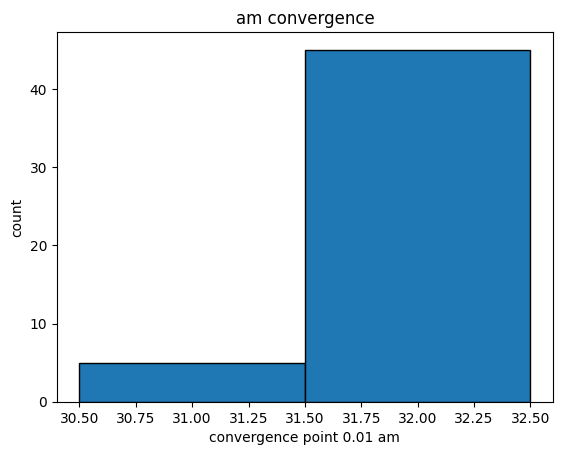

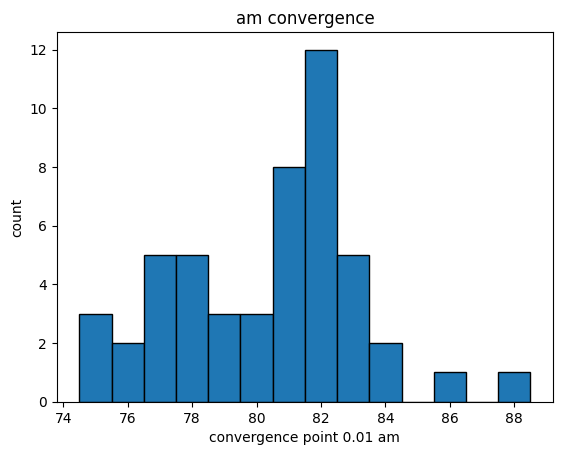

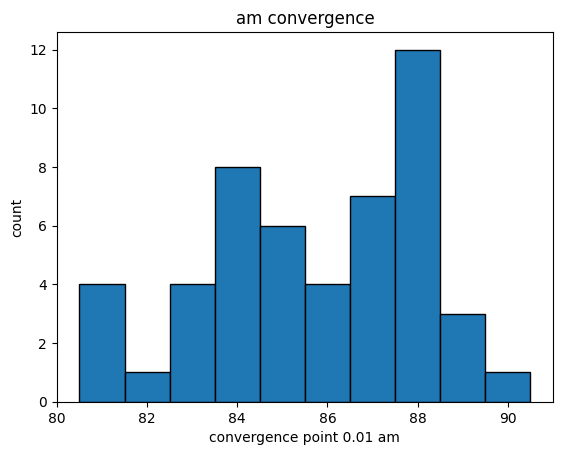

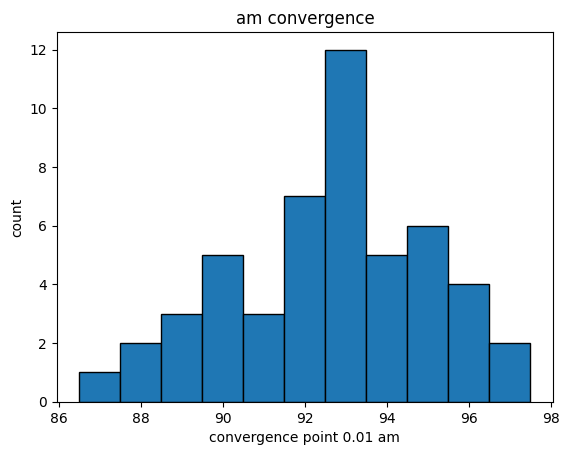

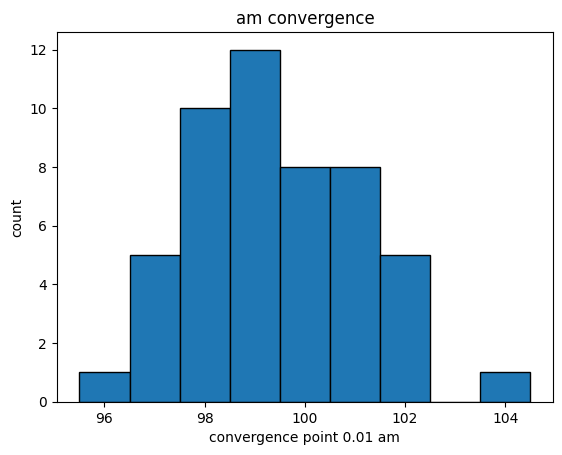

In [27]:
for subset in hist_prob_sets:
  histogram(subset, "am", 0.01)

In [21]:
def plot_categorized_dicts(f1, f2, f3, fl1, fl2, fl3, fn1, fn2, fn3, data, hydro, error, tol=1e-4):
    """
    f1, f2, f3, f4 : callable
        Functions applied to dicts.
    fn1, fn2, fn3 : list of float
        Possible reference values for f1, f2, f3.
    list_of_dict_lists : list of list of dict
        Each sublist is a group of dicts.
    tol : float
        Relative tolerance for matching (default 0.01% = 1e-4).
    """
    
    cp = lambda cf : cf[cf["m0s"][0]][f"convergence point {error:.2g} " + hydro]

    # colors for fn2 (color dimension)
    colors = plt.cm.tab10(np.linspace(0, 1, len(fl2)))
    fn2_to_color = {val: col for val, col in zip(fl2, colors)}

    # markers for fn3 (shape dimension)
    markers = ["o", "s", "^", "D", "v", "P", "X", "*", "<", ">"]
    fn3_to_marker = {val: markers[i % len(markers)] for i, val in enumerate(fl3)}
    print(fn2_to_color)
    print(fn3_to_marker)

    plt.figure(figsize=(10, 6))

    # loop over dict-lists
    for dict_list in data:
        if not dict_list:
            continue

        d0 = dict_list[0]

        # match f1, f2, f3 against fn1, fn2, fn3 with tolerance
        val1 = f1(d0)
        val2 = f2(d0)
        val3 = f3(d0)

        rep1 = next((x for x in fl1 if abs(val1 - x) <= tol * x), None)
        rep2 = next((x for x in fl2 if abs(val2 - x) <= tol * x), None)
        rep3 = next((x for x in fl3 if abs(val3 - x) <= tol * x), None)

        if rep1 is None or rep2 is None or rep3 is None:
            continue  # skip if no category match

        # compute mean, min, max for f4
        values = [cp(cf) for cf in dict_list]
        mean = np.mean(values)
        vmin = np.min(values)
        vmax = np.max(values)
        yerr = [[mean - vmin], [vmax - mean]]

        # plot point
        plt.errorbar(
            rep1, mean, yerr=yerr,
            fmt=fn3_to_marker[rep3], color=fn2_to_color[rep2],
            label=f"{rep2:.5g}, {rep3:.5g}"
                  if f"{rep2:.5g}, {rep3:.5g}" not in plt.gca().get_legend_handles_labels()[1] else ""
        )

    plt.xlabel(fn1)
    plt.ylabel(f"Convergence Point {error:.2g} " + hydro)
    plt.title("Categorized Dicts Plot")
    plt.grid(True)
    
    # legend outside
    plt.legend(title=(fn2 + " (color), " + fn3 + " (shape)"), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


{0.5: array([0.12156863, 0.46666667, 0.70588235, 1.        ]), 0.95: array([0.83921569, 0.15294118, 0.15686275, 1.        ]), 1.05: array([0.89019608, 0.46666667, 0.76078431, 1.        ]), 1.3: array([0.09019608, 0.74509804, 0.81176471, 1.        ])}
{0.1: 'o', 0.2: 's'}


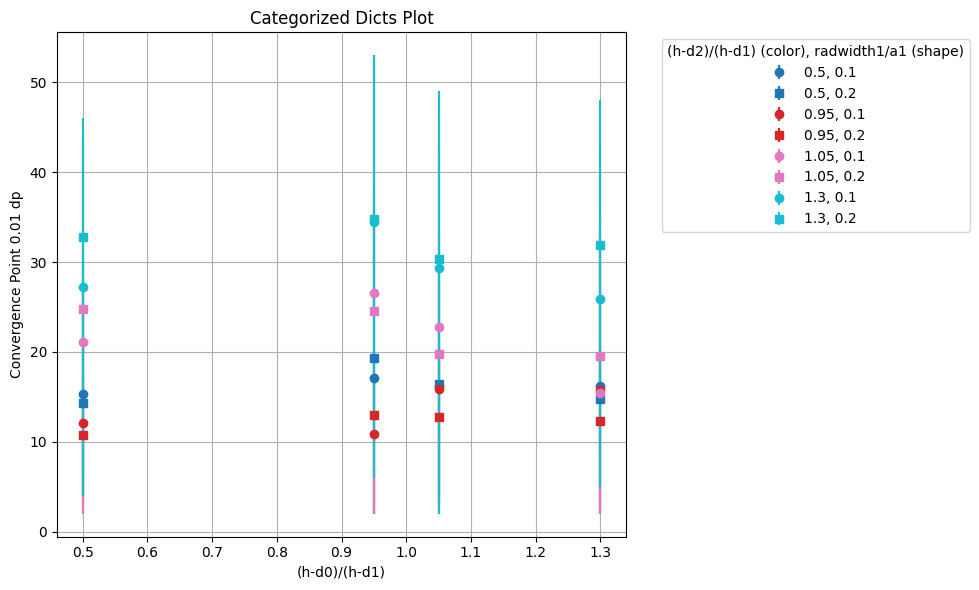

In [23]:
f1 = lambda cf: (cf["h"]-cf["d"][0])/(cf["h"]-cf["d"][1])
f2 = lambda cf: (cf["h"]-cf["d"][2])/(cf["h"]-cf["d"][1])
f3 = lambda cf: (cf["a"][1]-cf["a"][0])/cf["a"][1]
plot_categorized_dicts(f1, f2, f3, left_ratios, right_ratios, rad_ratios,
                       "(h-d0)/(h-d1)", "(h-d2)/(h-d1)", "radwidth1/a1", hist_prob_sets, "dp", 0.01, tol=1e-4)

In [4]:
# Generate a dicionary of ratios.
def hmdi(data_dict, i):
  return data_dict["h"] - data_dict["d"][i]

def di(data_dict, i):
  return data_dict["d"][i]

def radwidthi(data_dict, i):
  return data_dict["a"][i] - (0 if i == 0 else data_dict["a"][i-1])

def radrange(data_dict, i, j):
  return sum([radwidthi(data_dict, k) for k in range(i+1, j + 1)])

dim1s = {"h" : lambda data_dict, m0: data_dict["h"],
        "(1/m0)" : lambda data_dict, m0: 1/m0}

for i in range(3):
  dim1s["d" + str(i)] = lambda data_dict, m0, i=i : di(data_dict, i)
  dim1s["(h-d" + str(i) + ")"] = lambda data_dict, m0, i=i: hmdi(data_dict, i)
  dim1s["radwidth" + str(i)] = lambda data_dict, m0, i=i: radwidthi(data_dict, i)
  dim1s["a" + str(i)] = lambda data_dict, m0, i=i: radrange(data_dict, -1, i)
  for j in range(i + 2, 3):
    dim1s["(a" + str(j) + "-a" + str(i) + ")"] = lambda data_dict, m0, i=i, j=j : radrange(data_dict, i, j)

dim0s = {} # size = 15**2
for key1 in dim1s.keys():
  for key2 in dim1s.keys():
    if key1 == key2:
      pass
    else:
      dim0s[key1 + "/" + key2] = (lambda data_dict, m0, k1 = key1, k2 = key2 : dim1s[k1](data_dict, m0)/dim1s[k2](data_dict, m0))

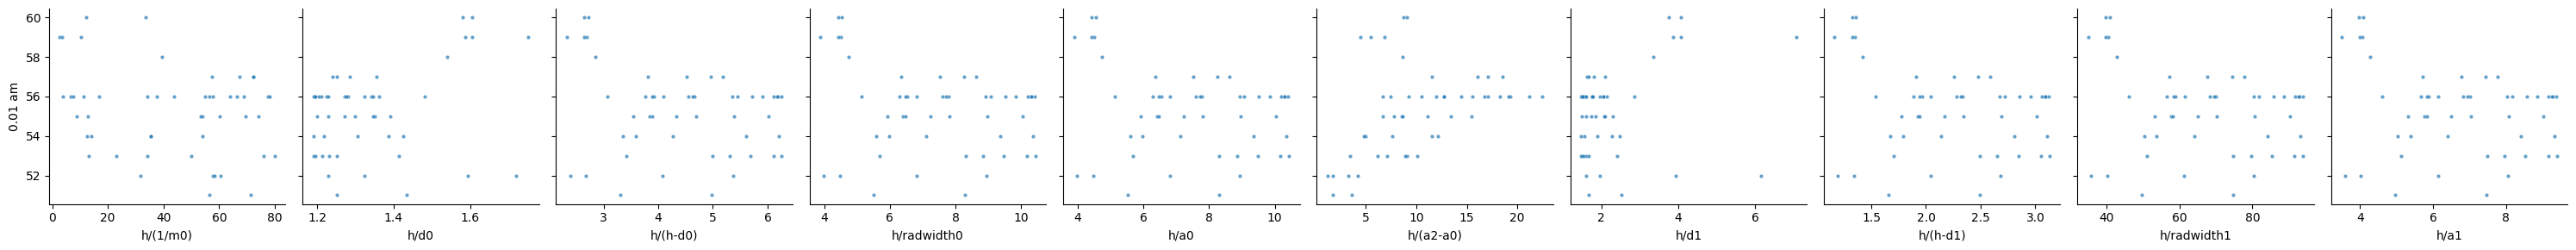

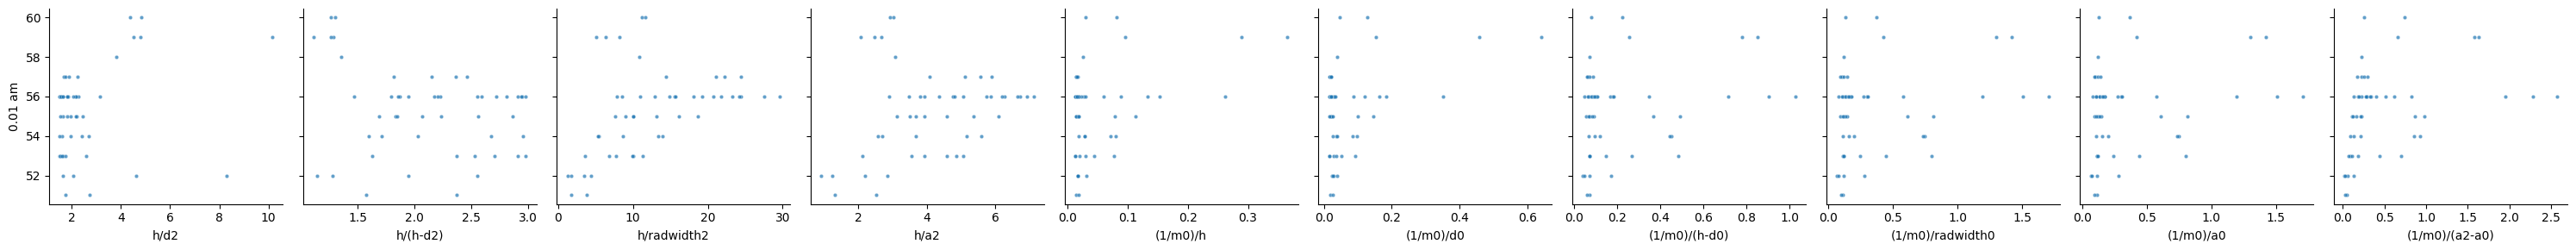

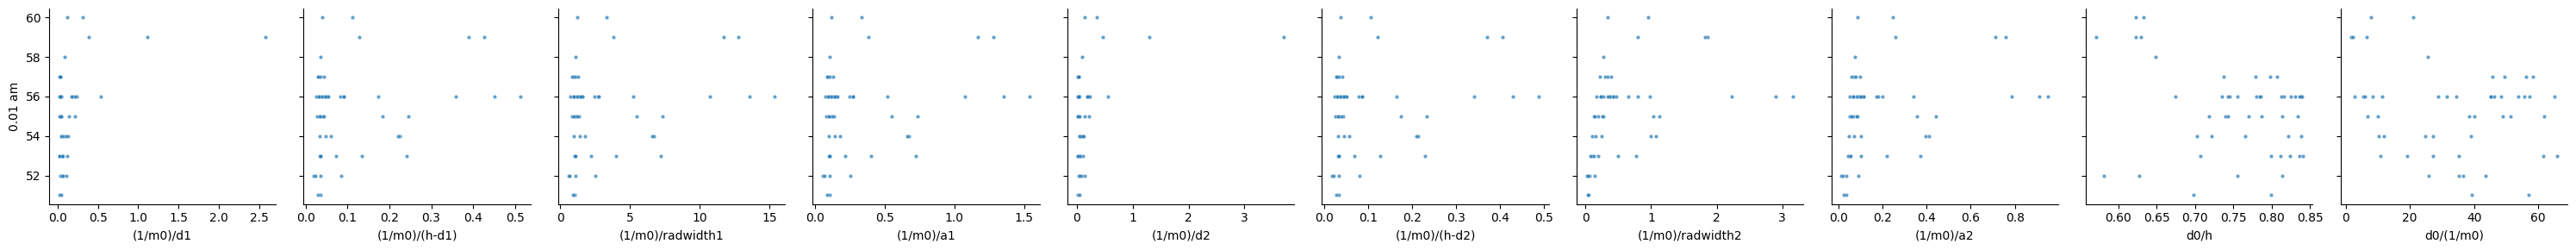

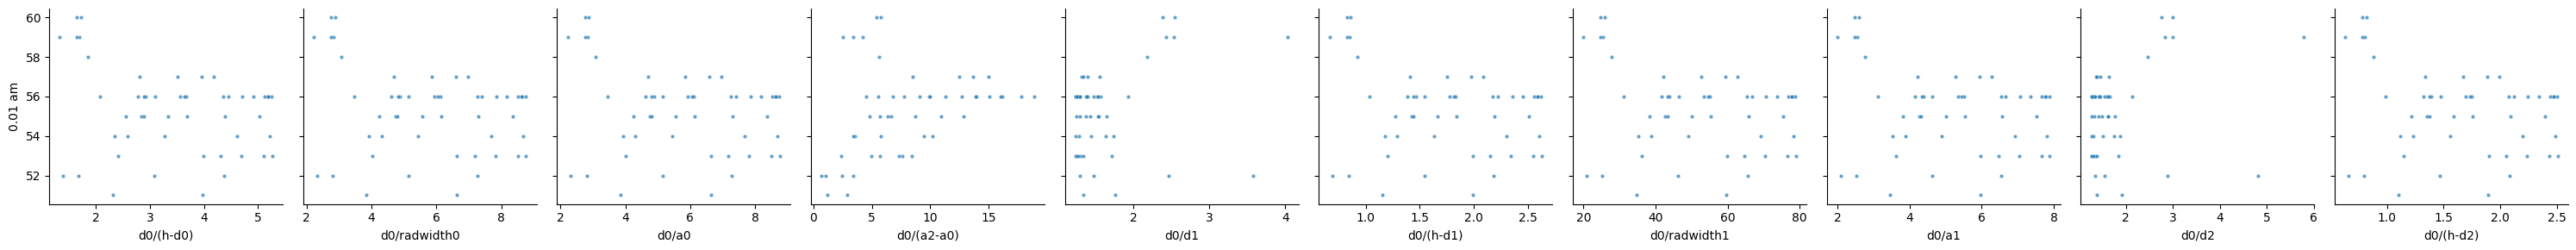

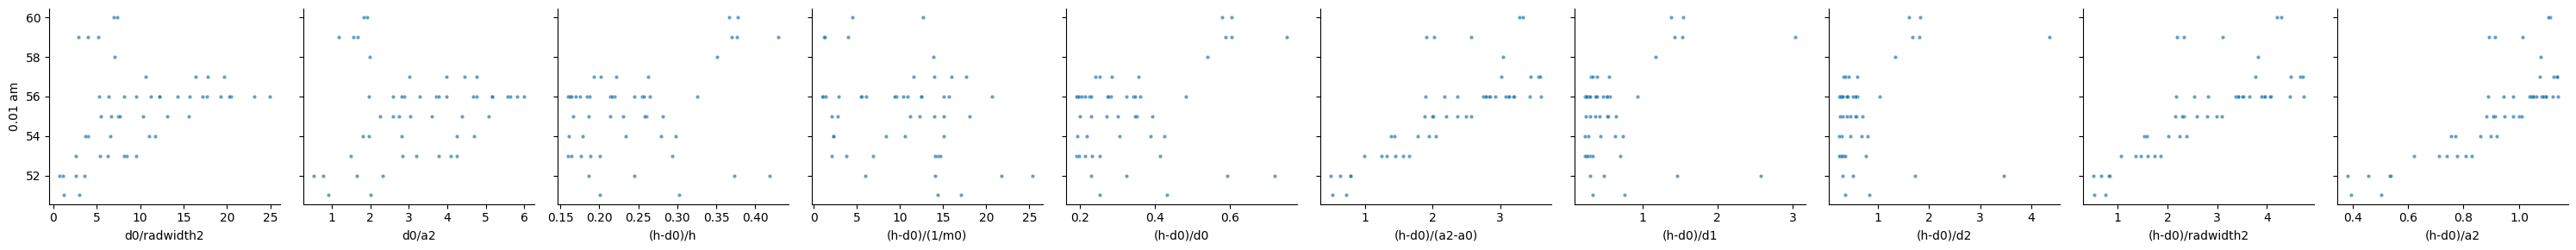

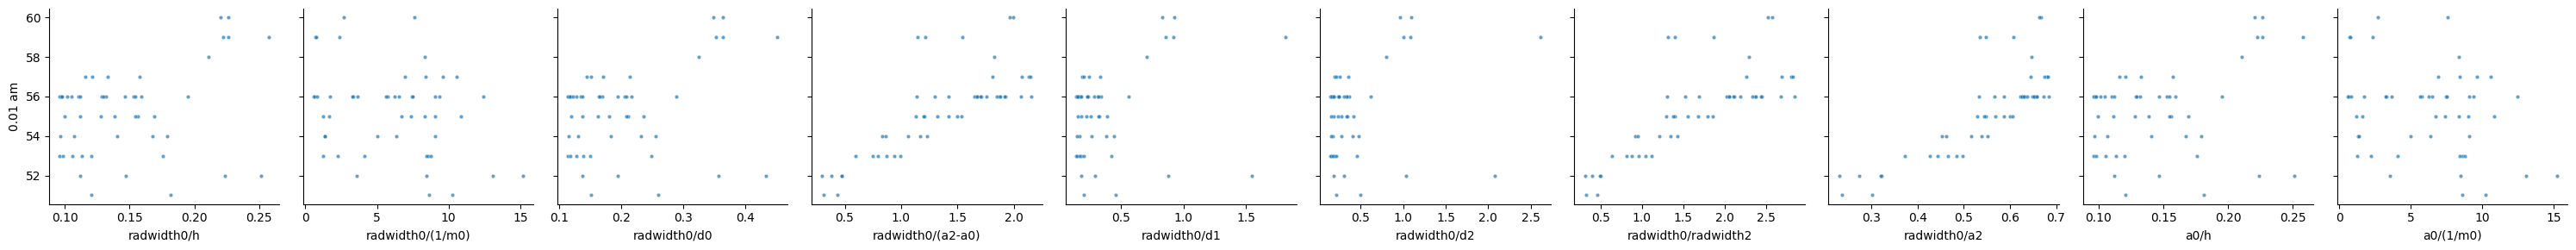

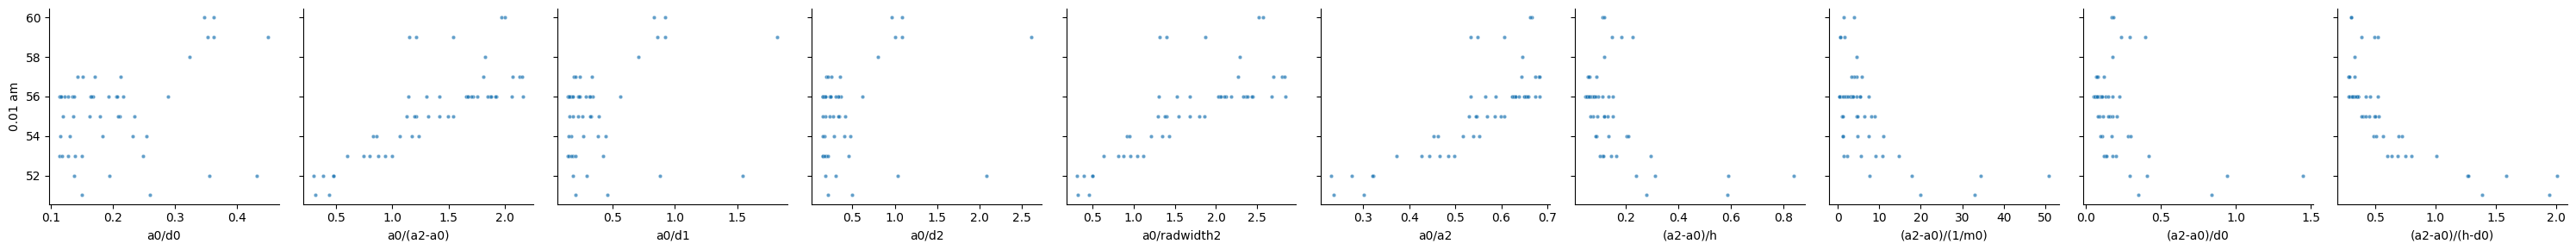

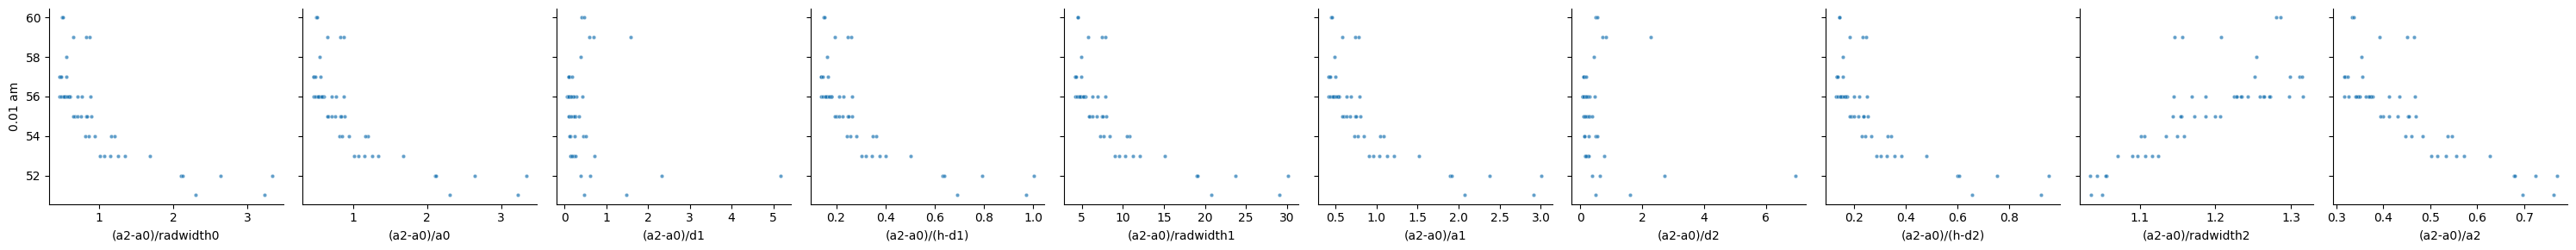

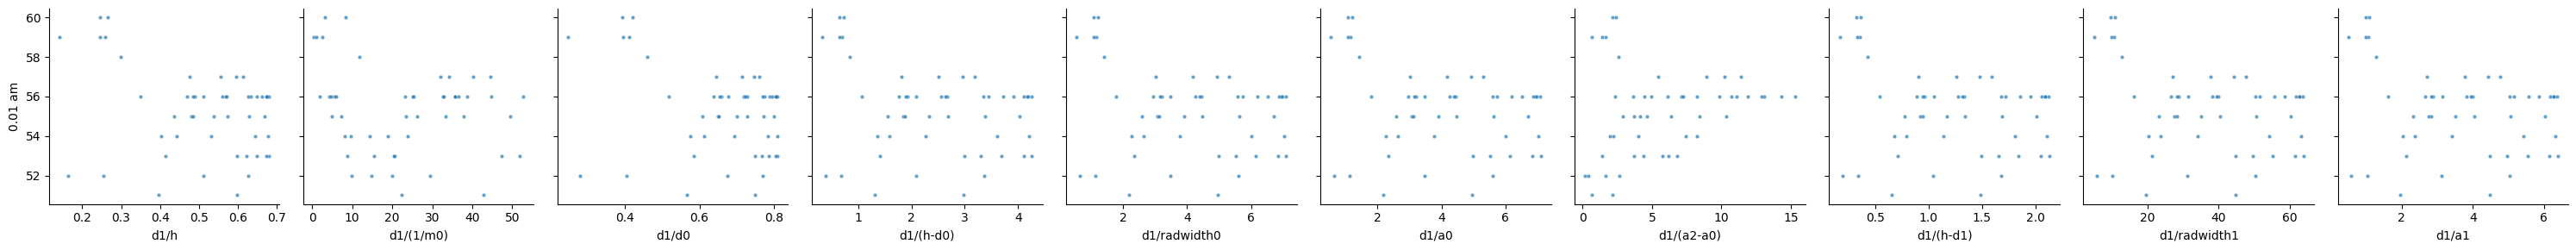

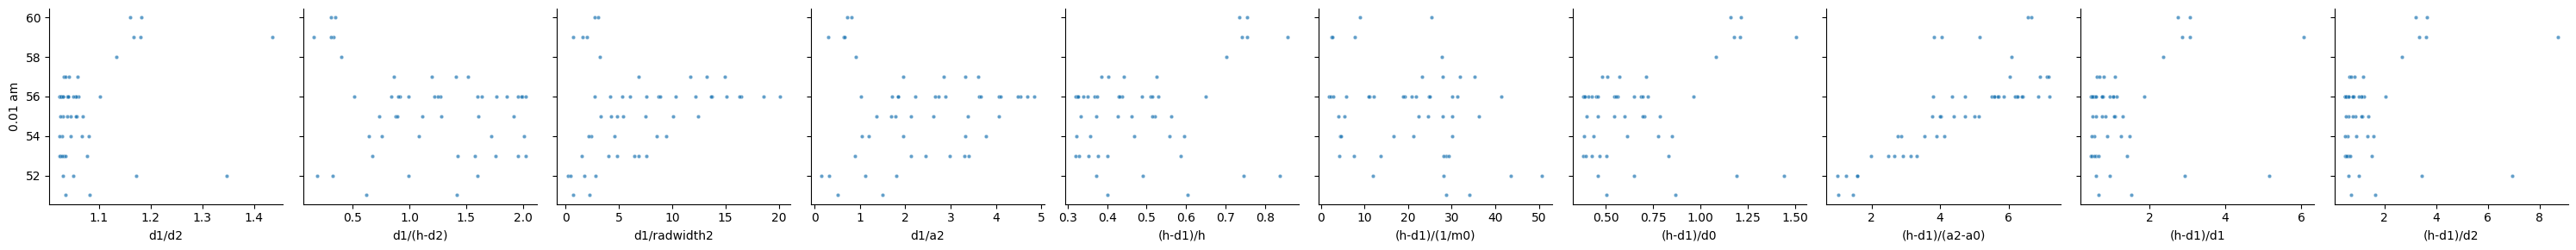

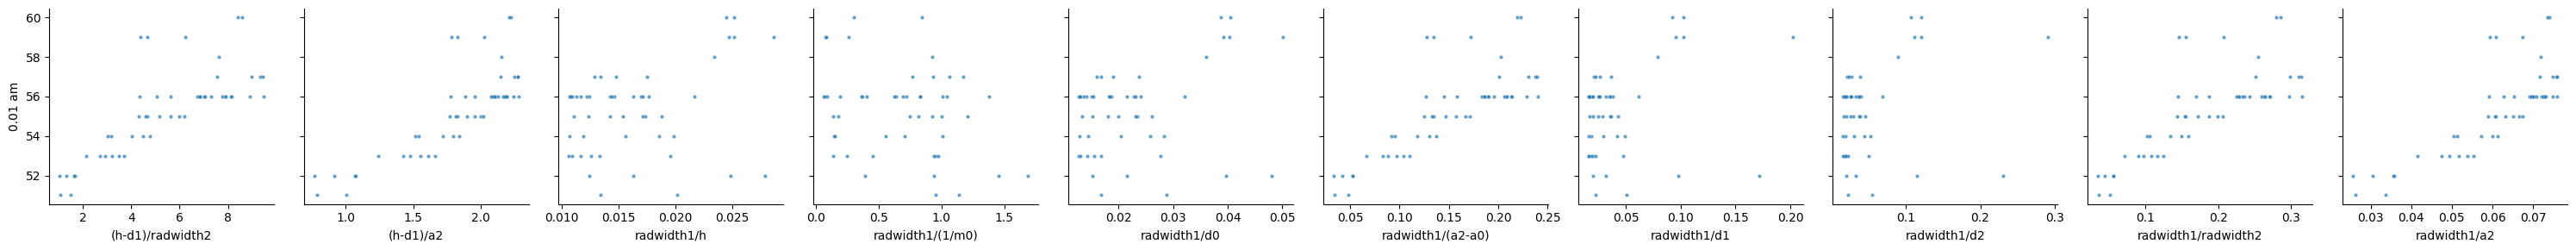

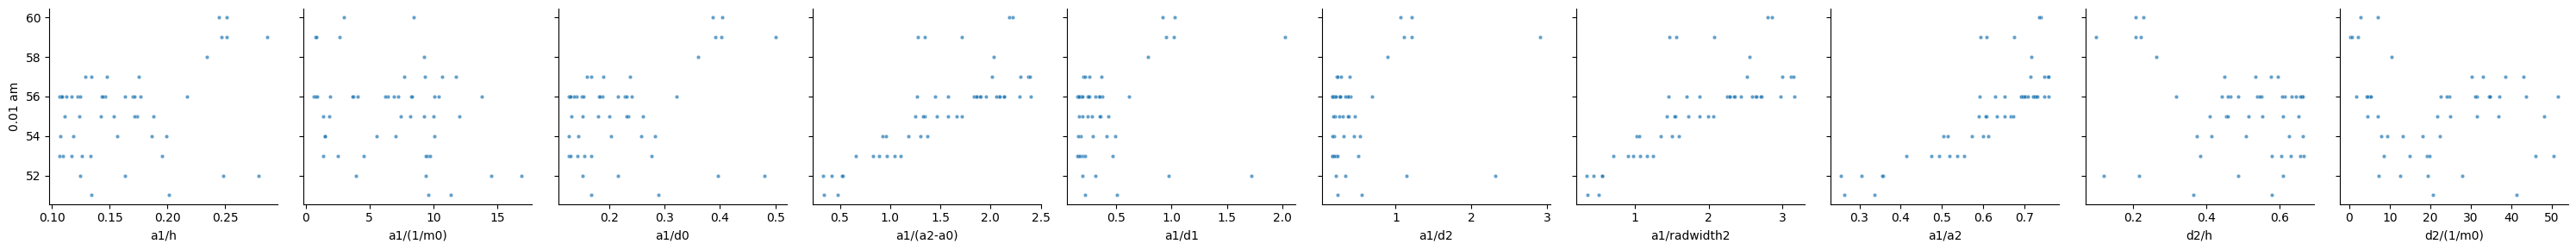

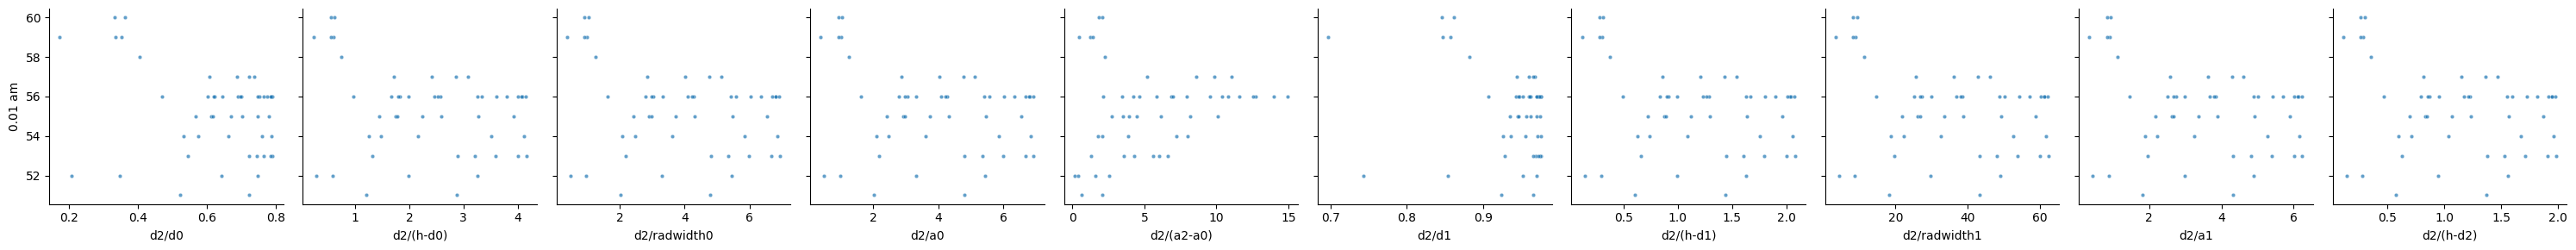

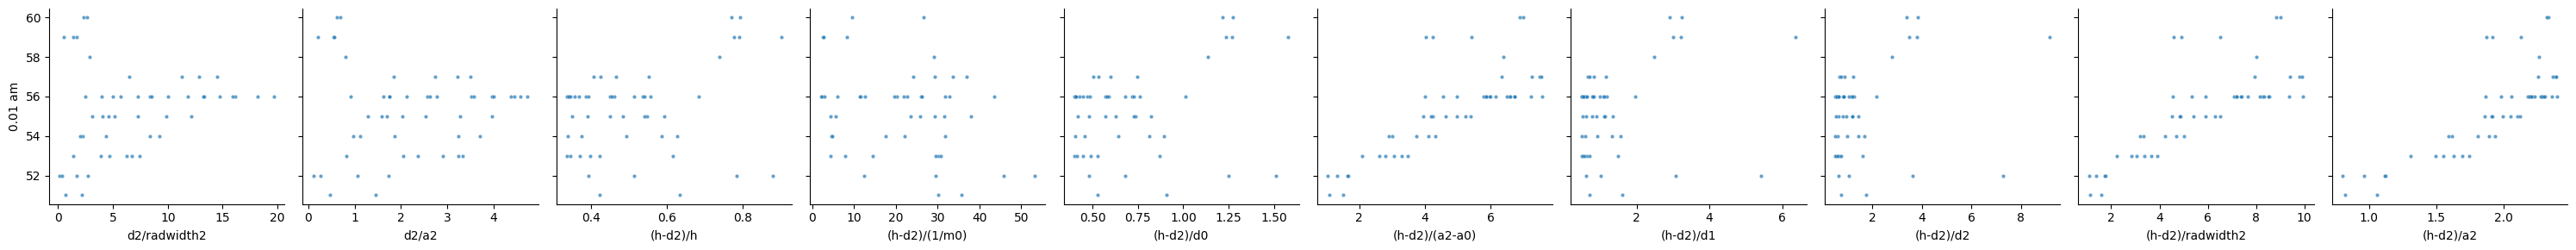

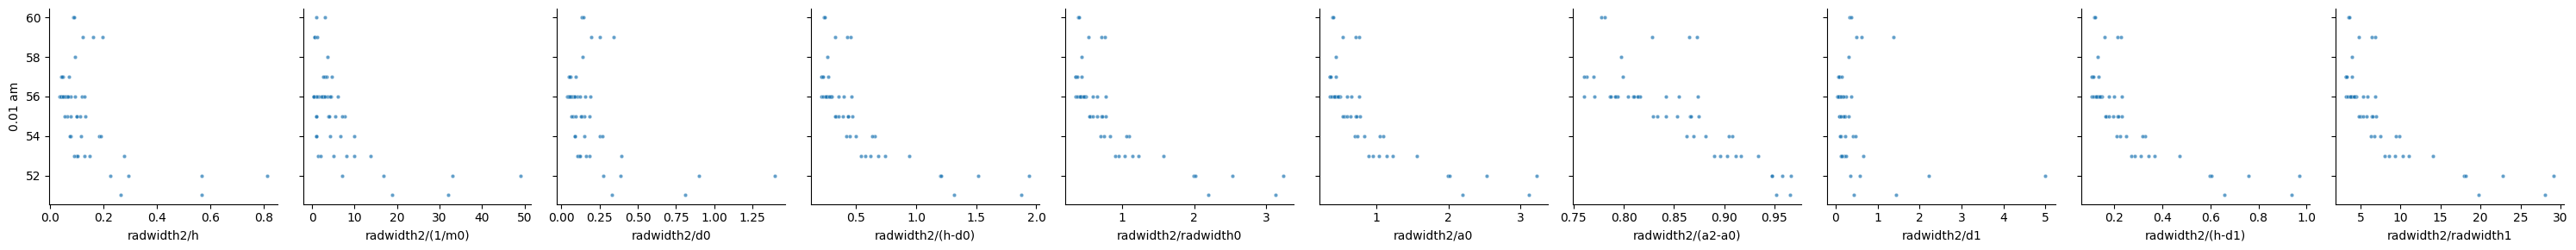

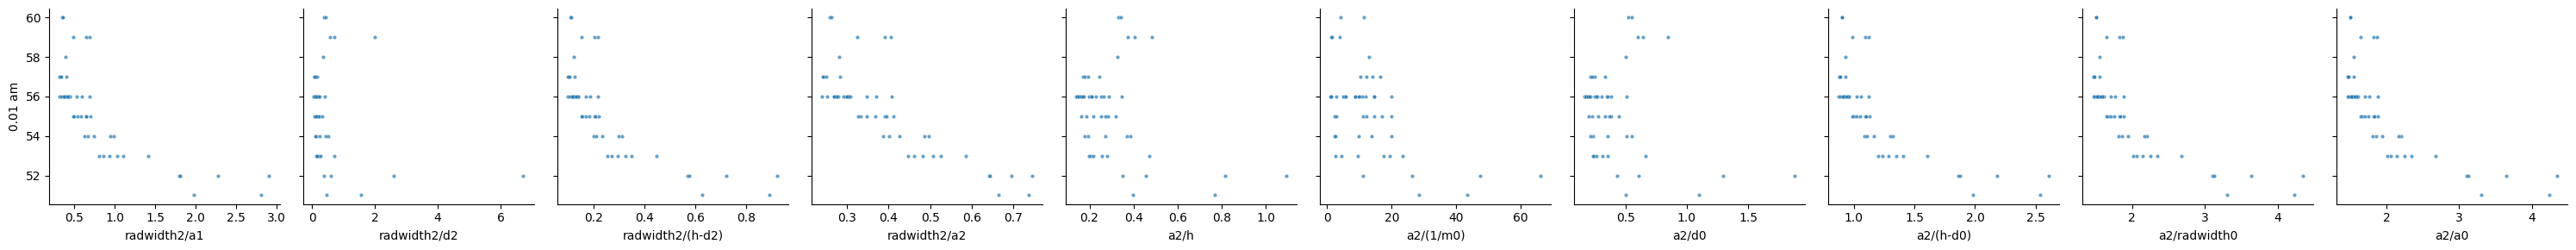

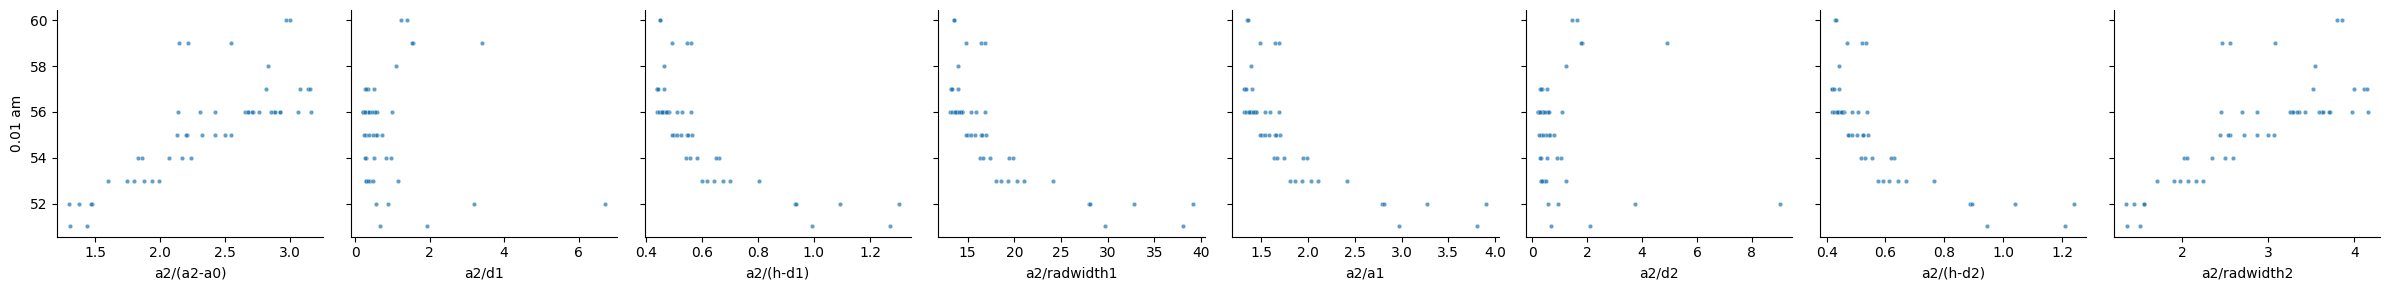

In [31]:
y_funcs = {"0.01 am" : (lambda data_dict, m0 : data_dict[m0]["convergence point 0.01 am"])}#,
           # "0.01 dp" : (lambda data_dict, m0 : data_dict[m0]["convergence point 0.01 dp"])}

suspects = hist_prob_sets[4]
count = 0
plot_fs = {}
for func_label in dim0s.keys():
  variable_vals = [dim0s[func_label](suspect, m0) for suspect in suspects for m0 in suspect["m0s"]]
  min_v, max_v = min(variable_vals), max(variable_vals)
  if abs(max_v-min_v)/max_v > 0.00001:
    plot_fs[func_label] = dim0s[func_label]
    count += 1
    if count == 10:
      plot_relation_grid(suspects, plot_fs, y_funcs)
      count, plot_fs = 0, {}
if count != 0:
  plot_relation_grid(suspects, plot_fs, y_funcs)

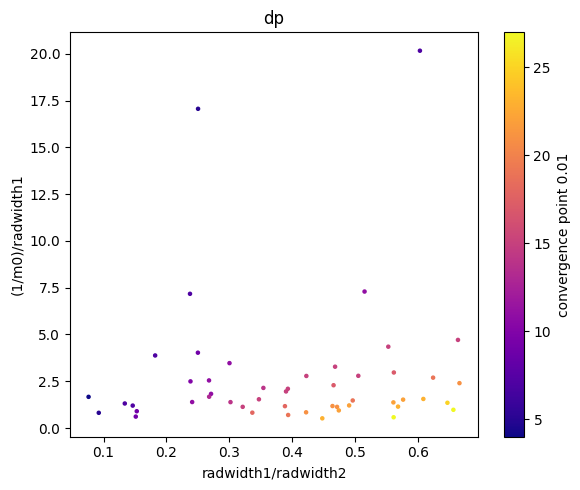

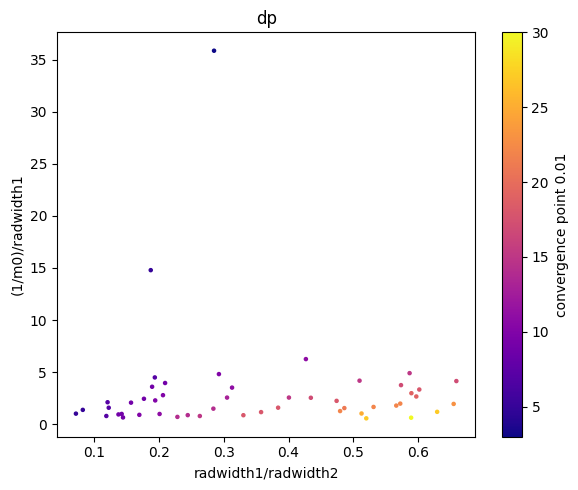

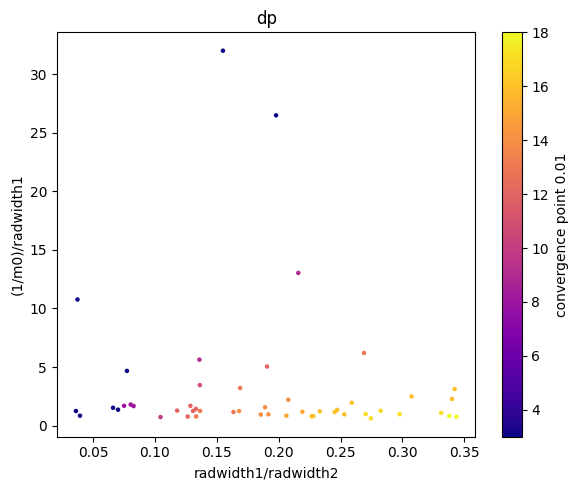

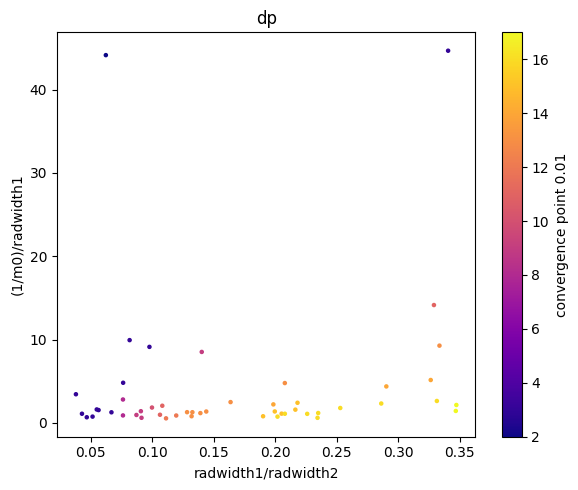

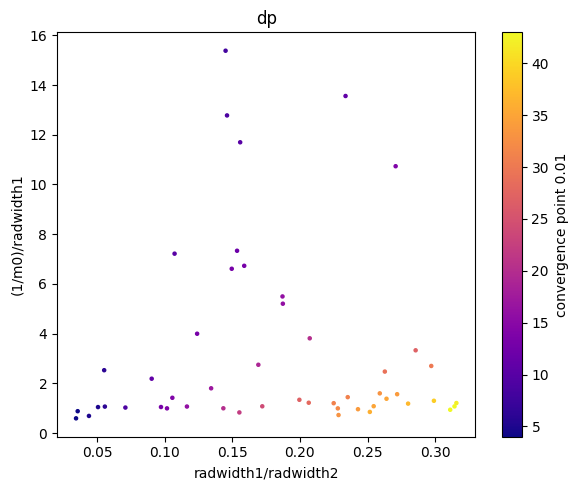

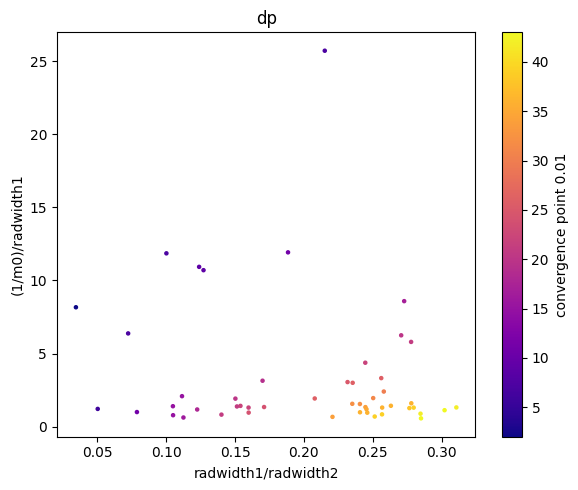

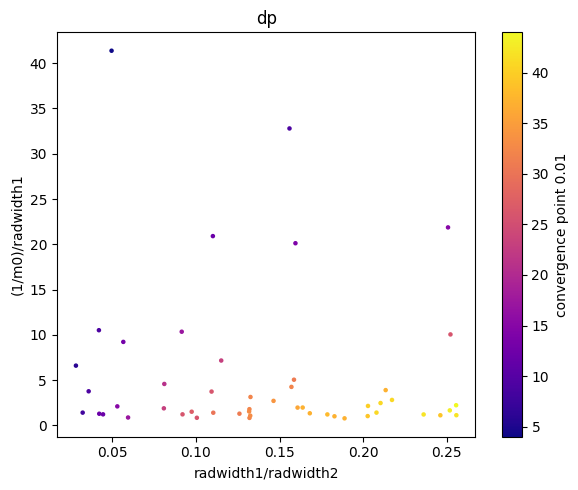

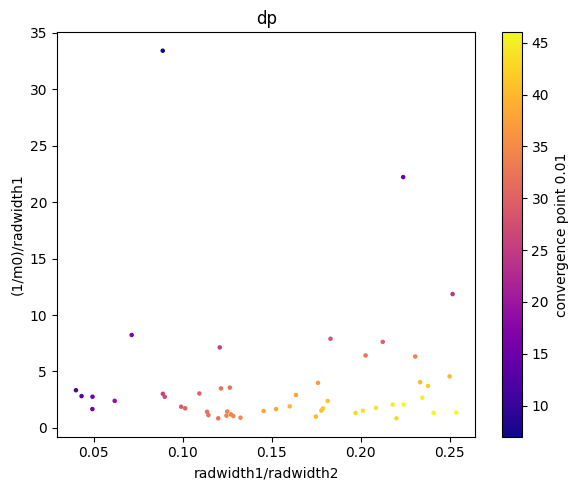

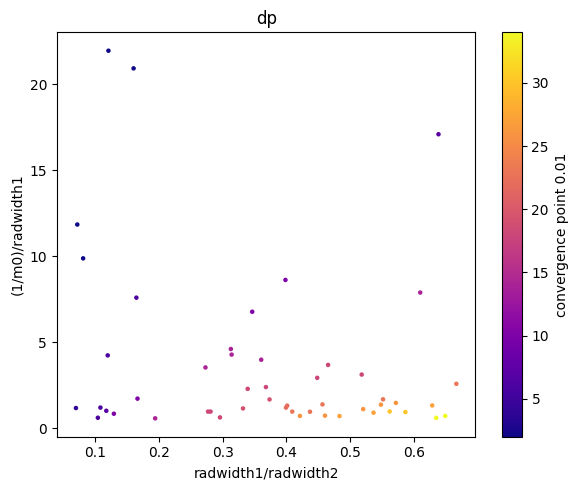

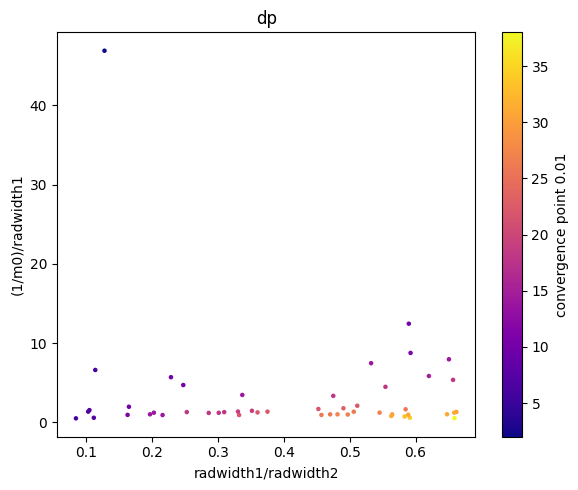

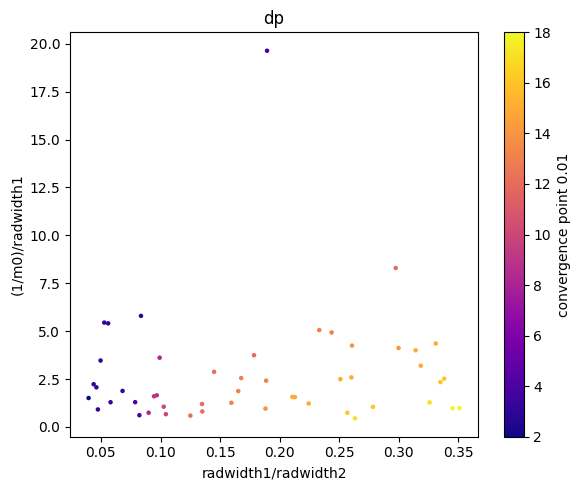

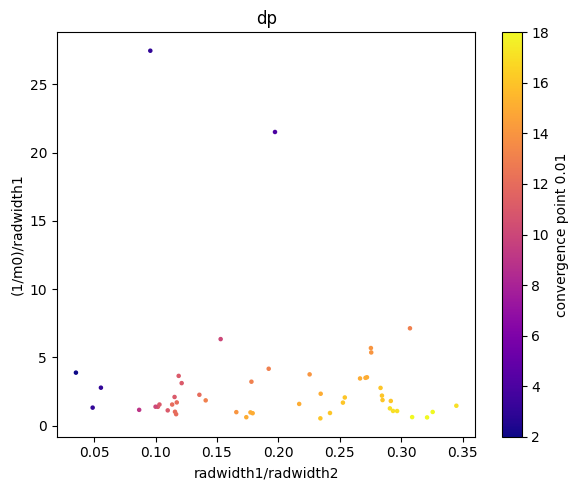

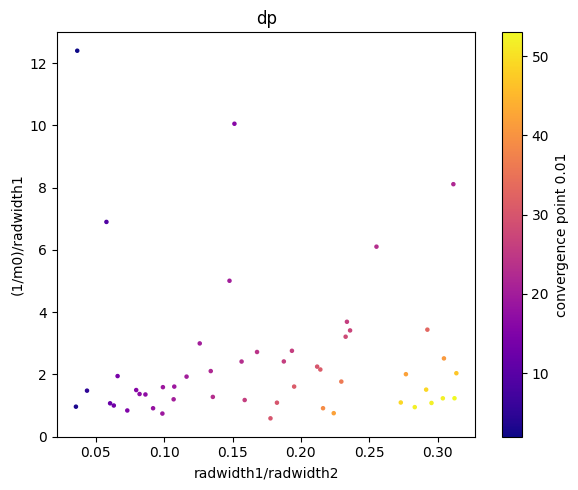

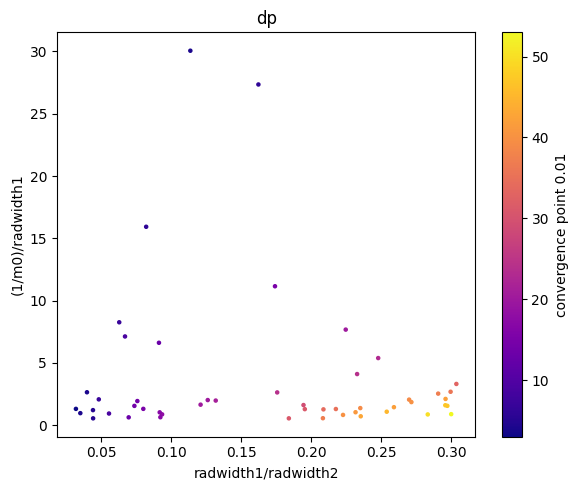

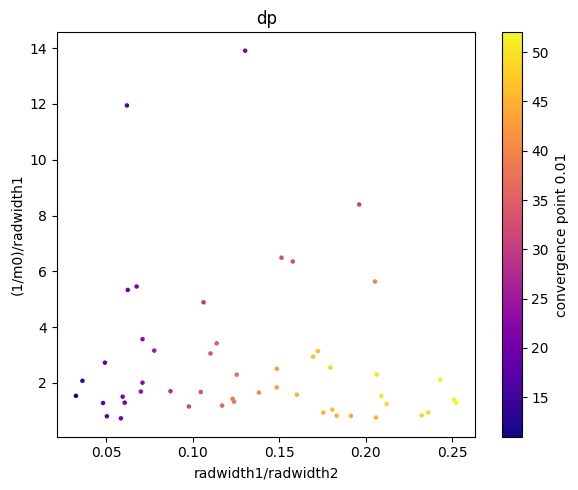

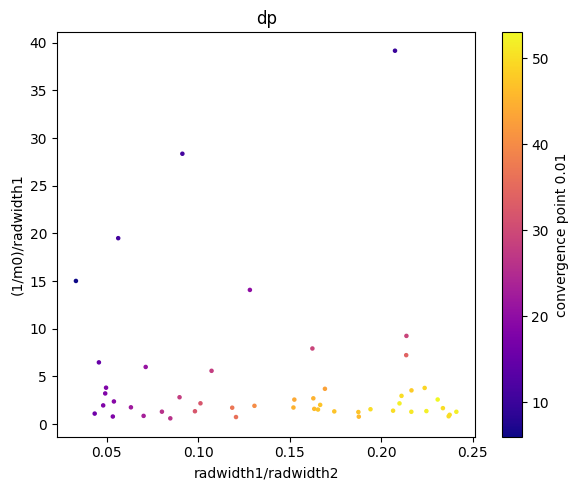

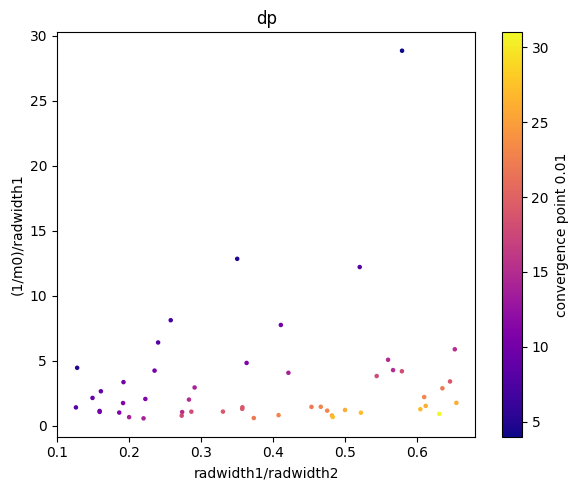

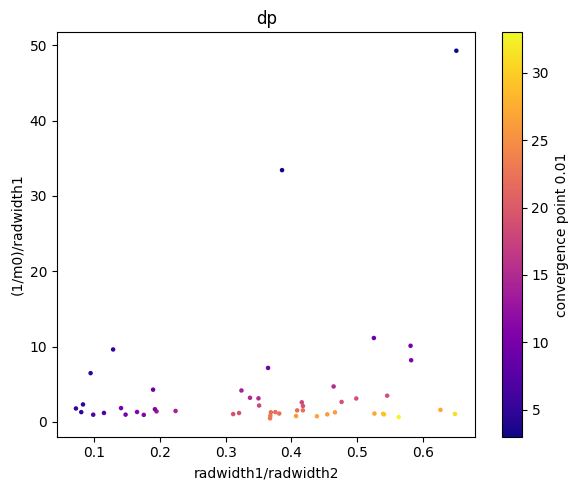

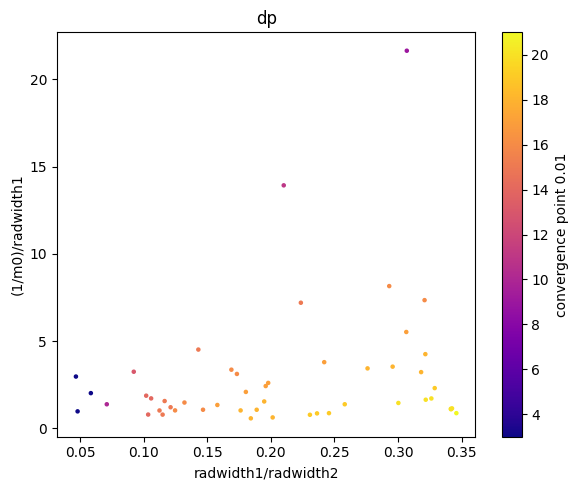

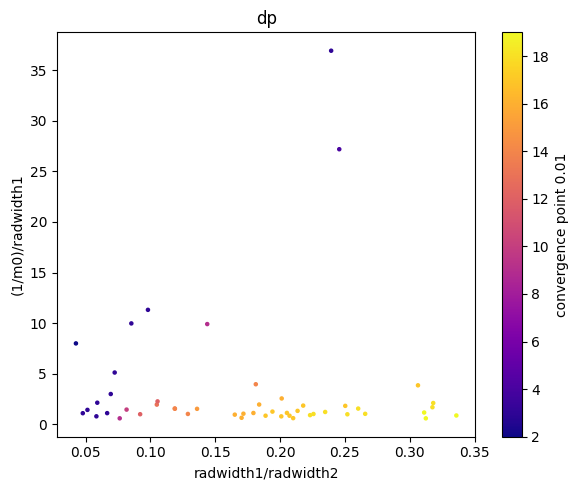

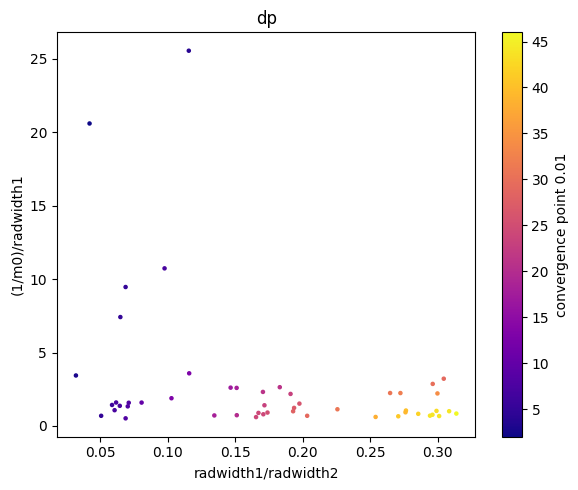

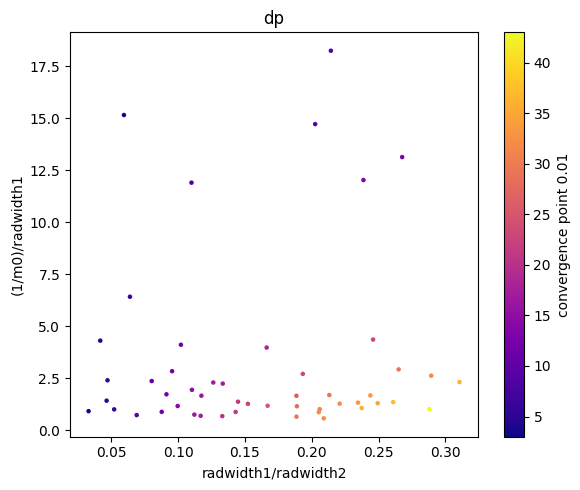

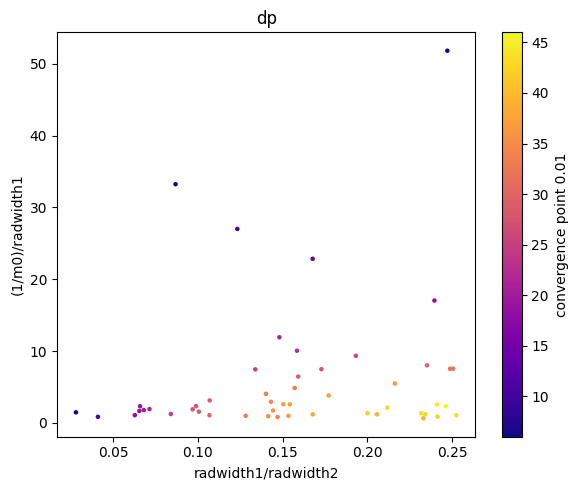

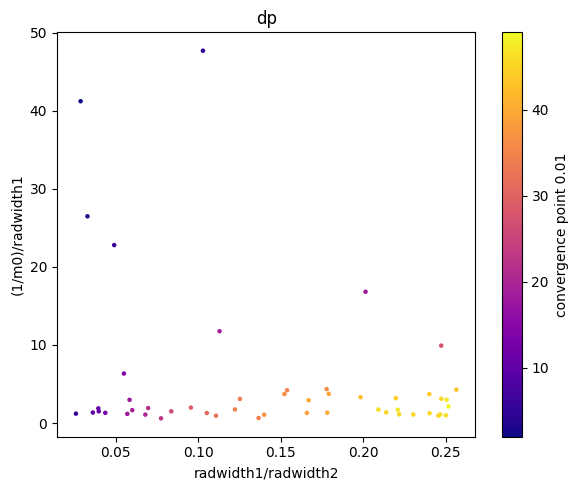

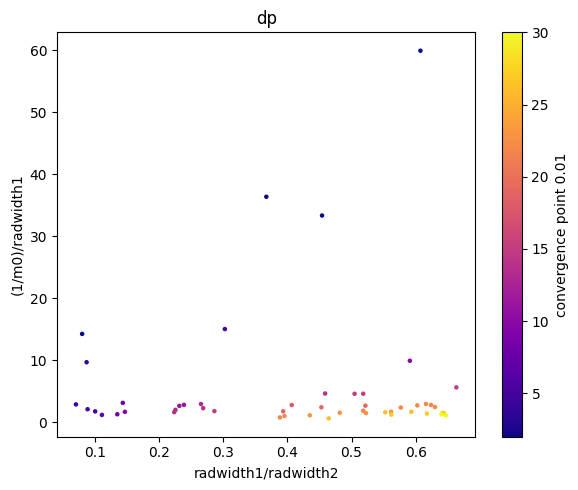

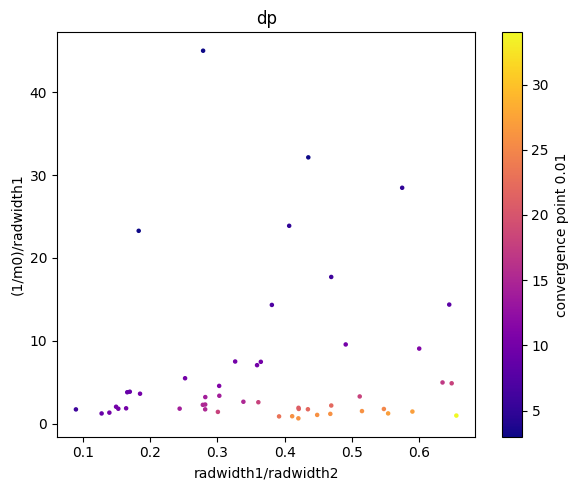

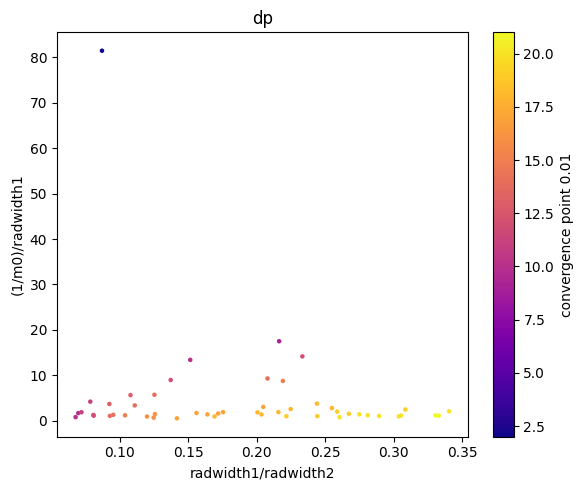

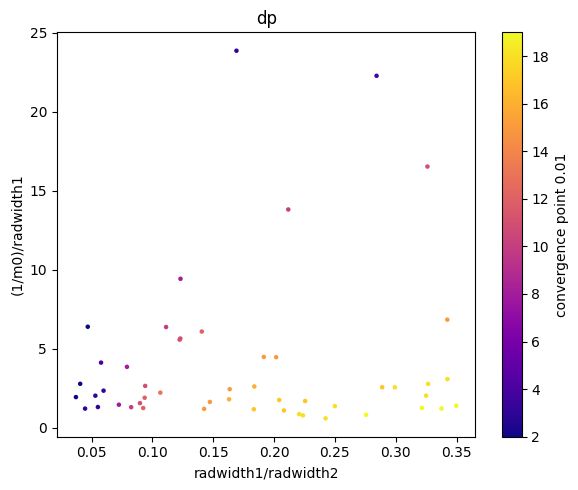

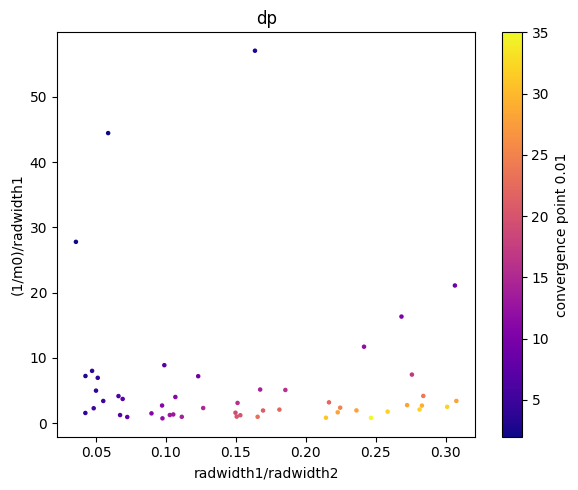

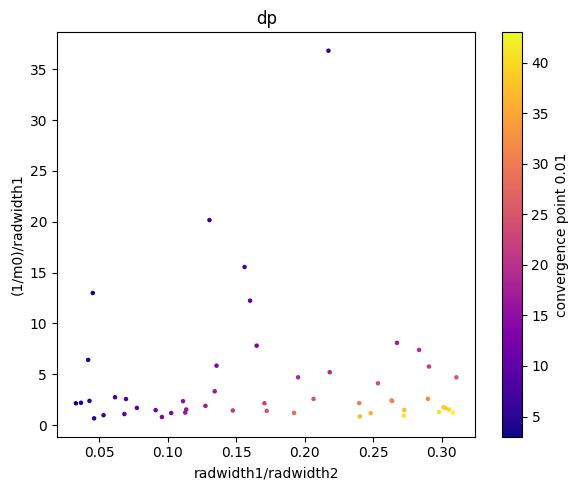

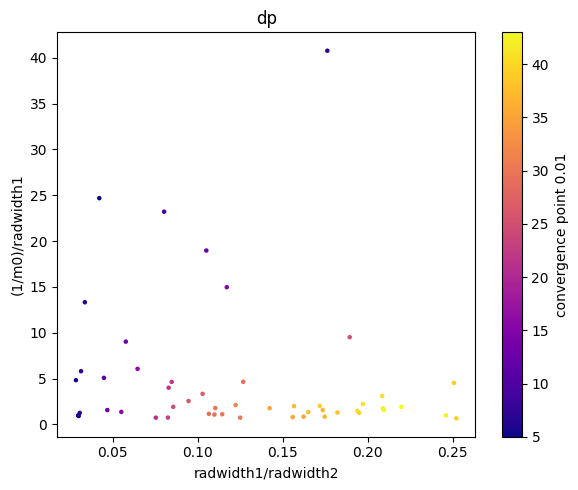

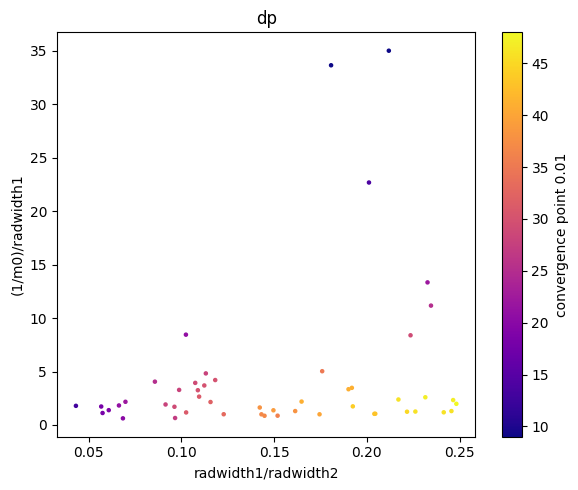

In [7]:
for prob_set in hist_prob_sets:
  plot_hydros_against_2(prob_set, "dp", 0.01, dim0s["radwidth1/radwidth2"], dim0s["(1/m0)/radwidth1"], "radwidth1/radwidth2", "(1/m0)/radwidth1")

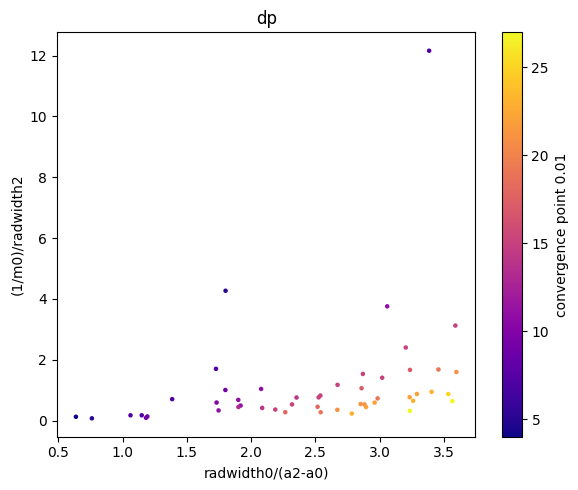

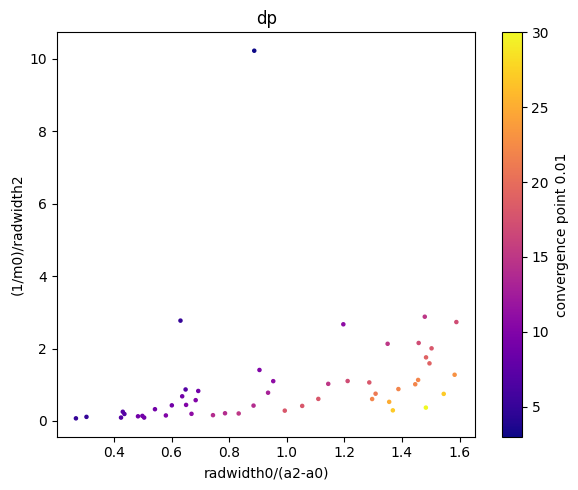

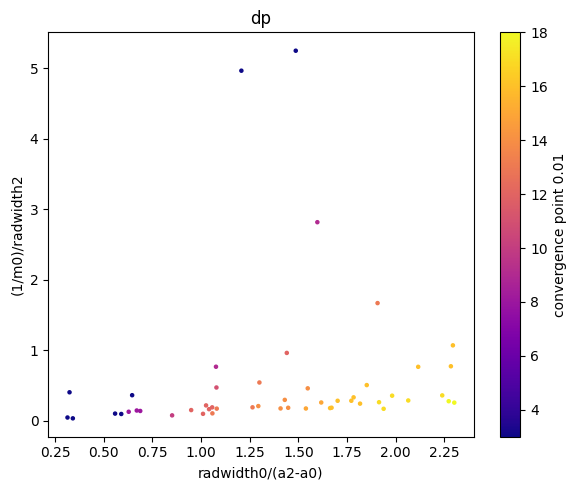

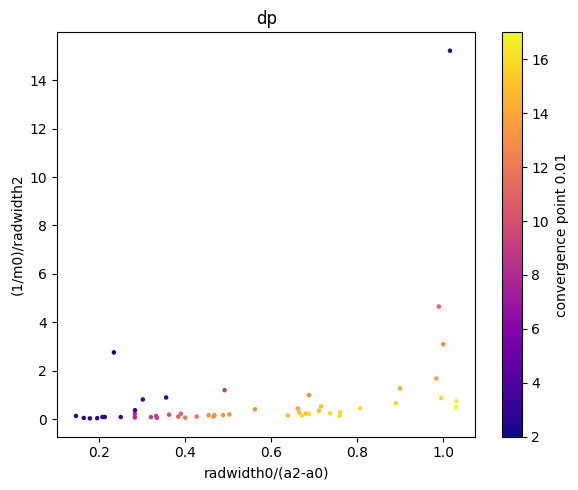

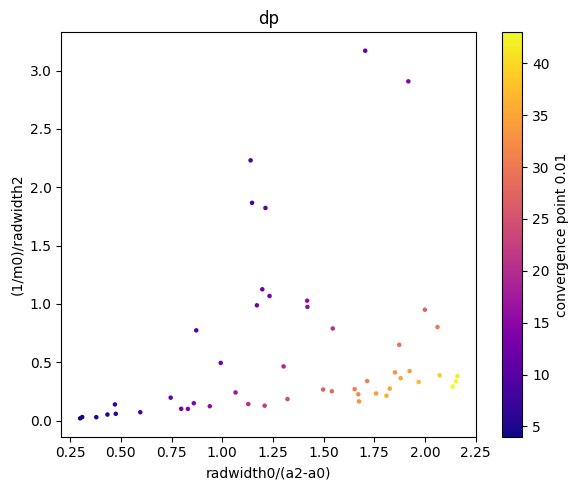

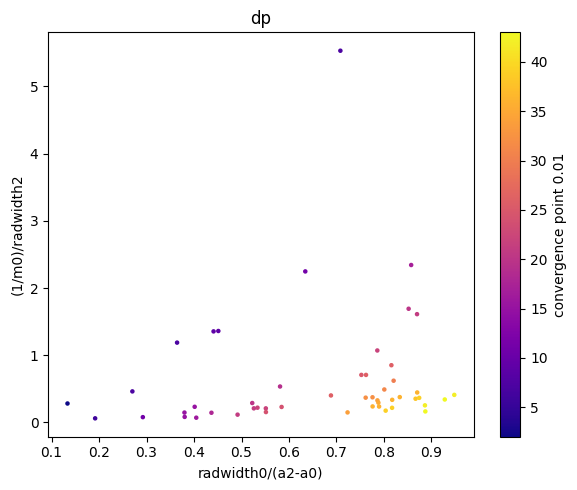

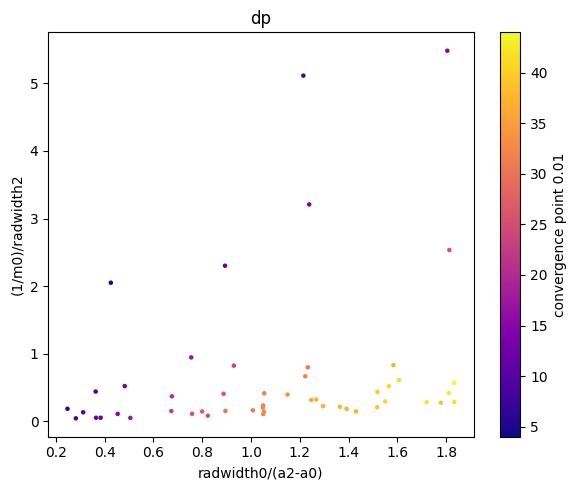

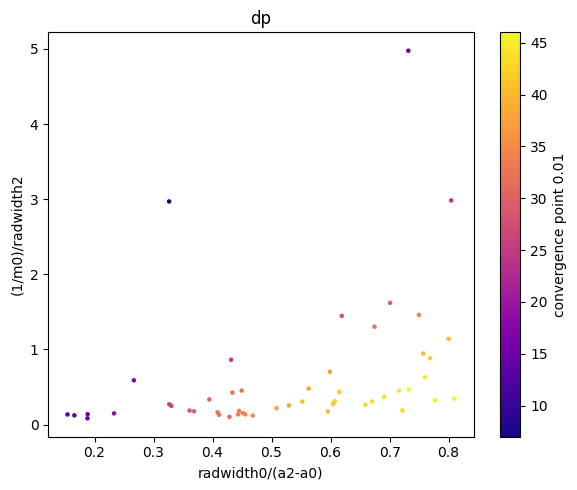

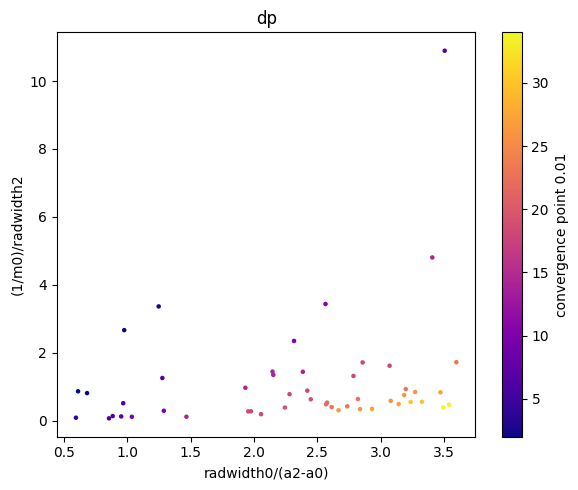

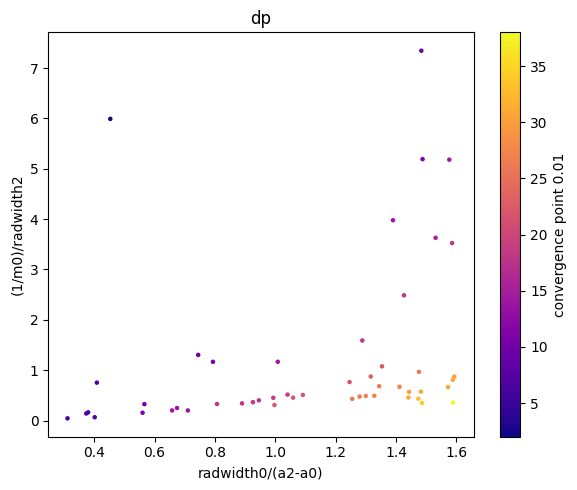

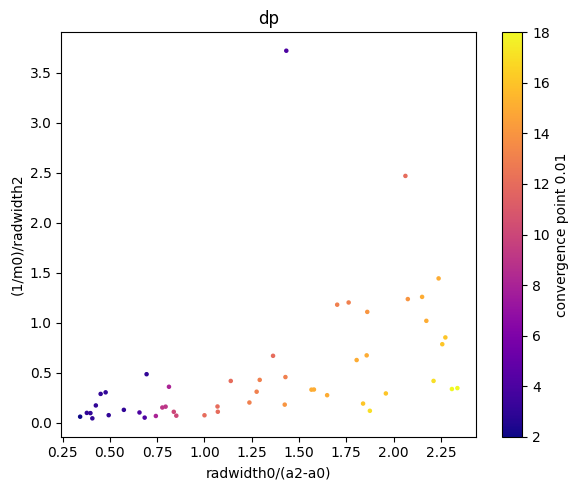

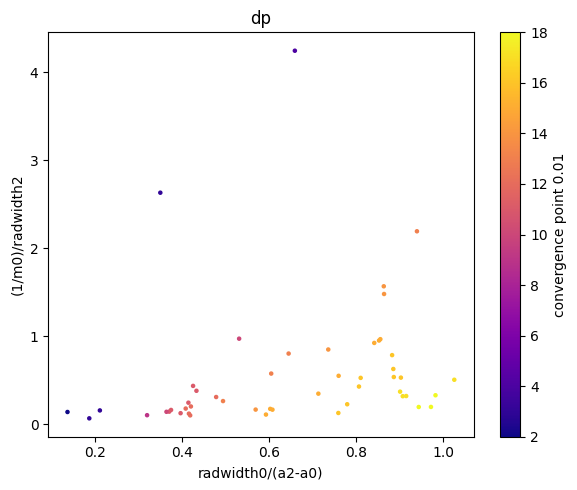

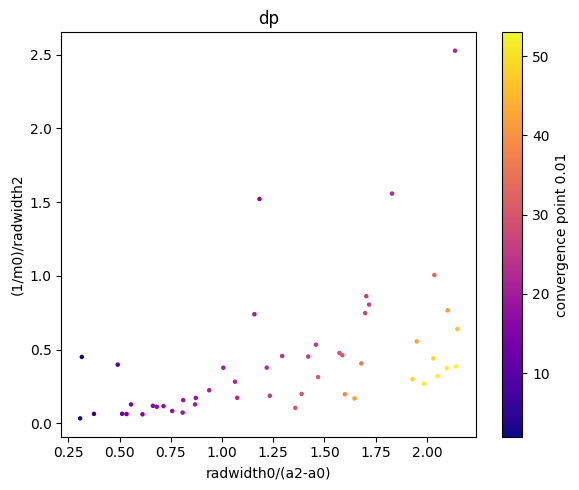

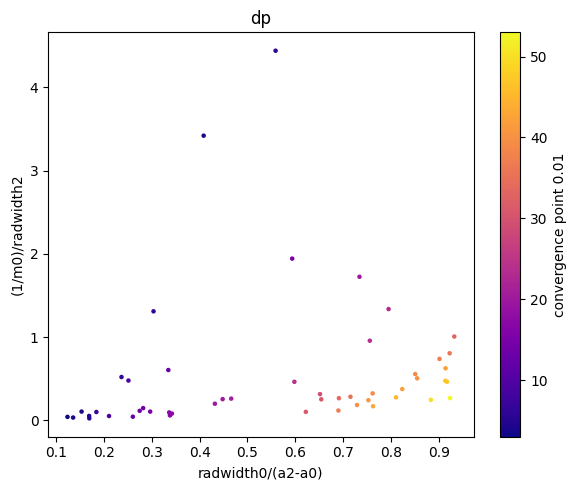

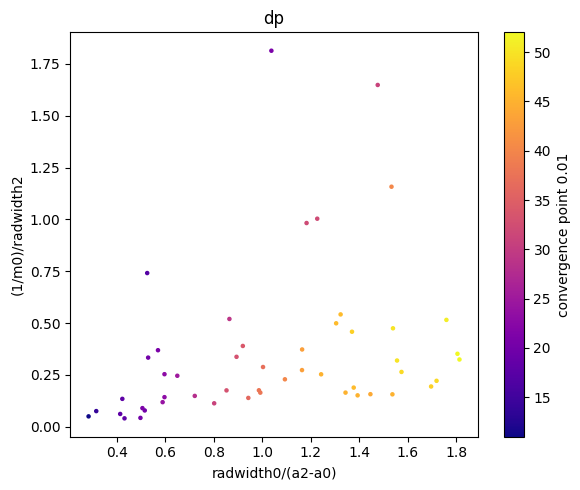

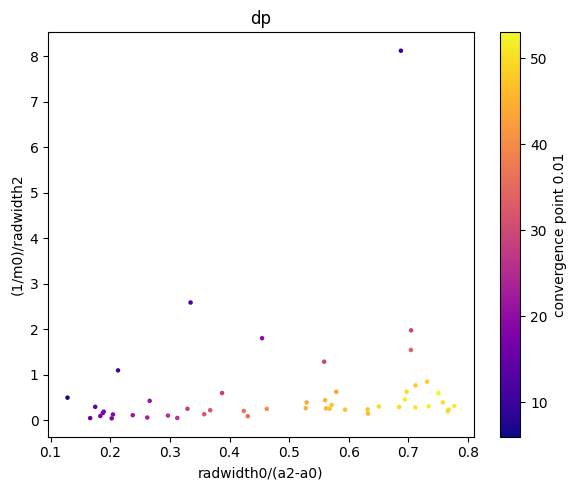

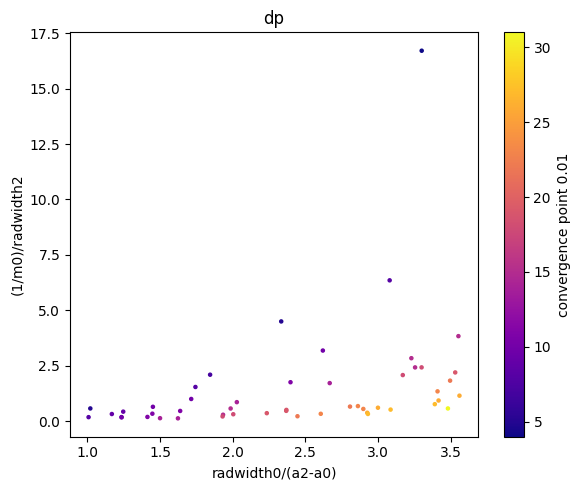

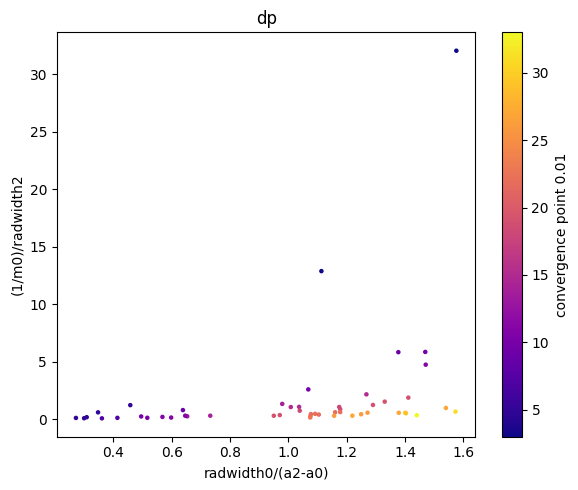

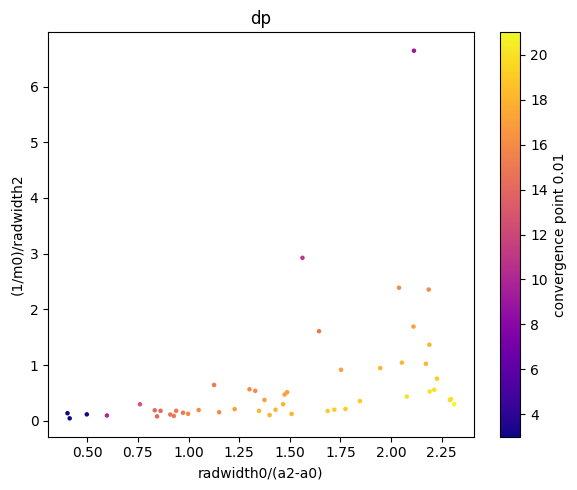

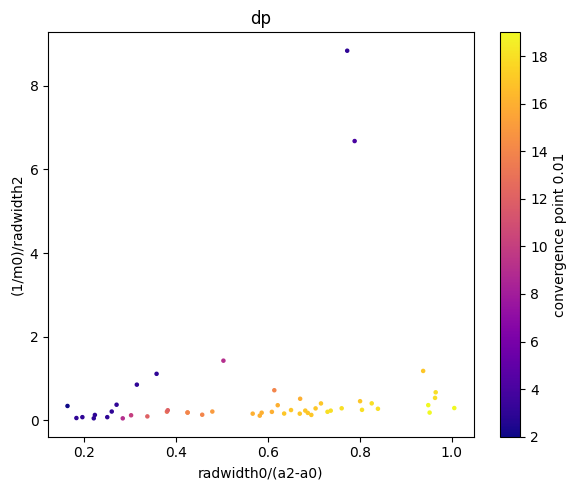

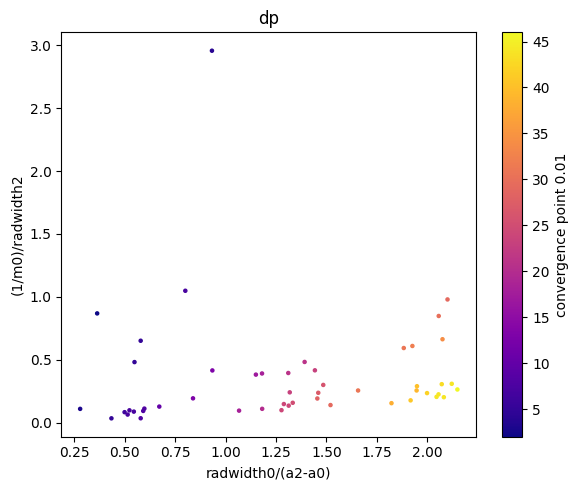

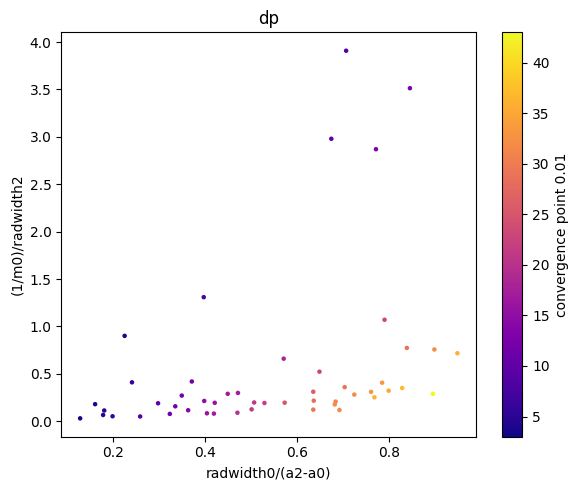

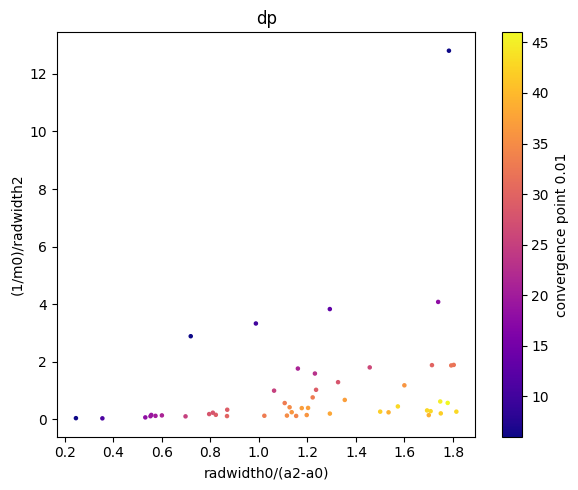

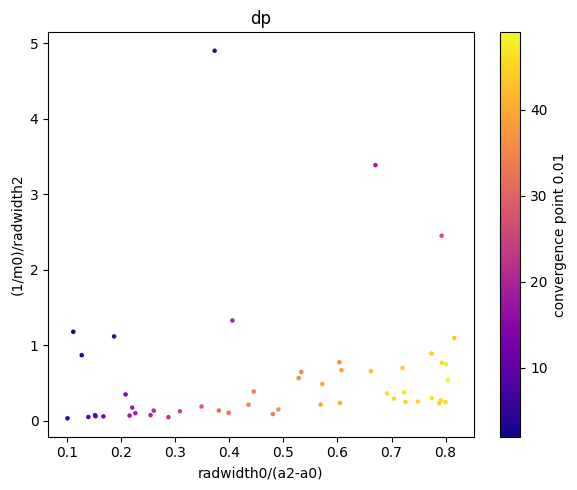

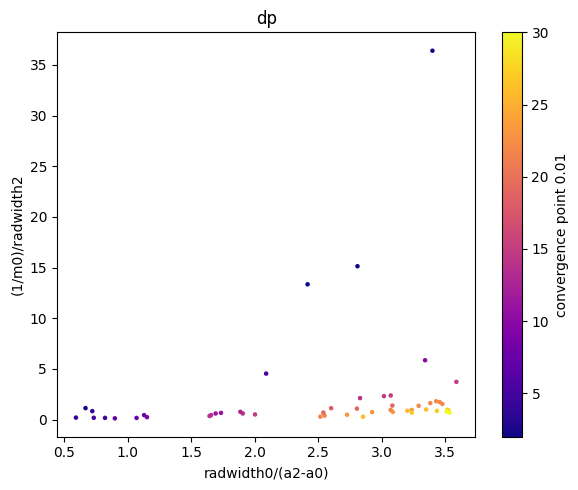

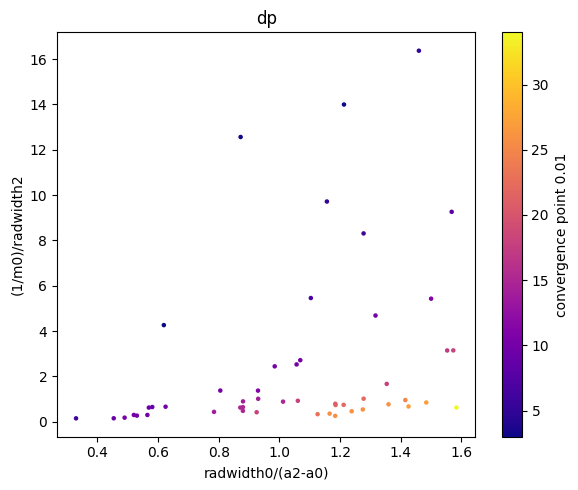

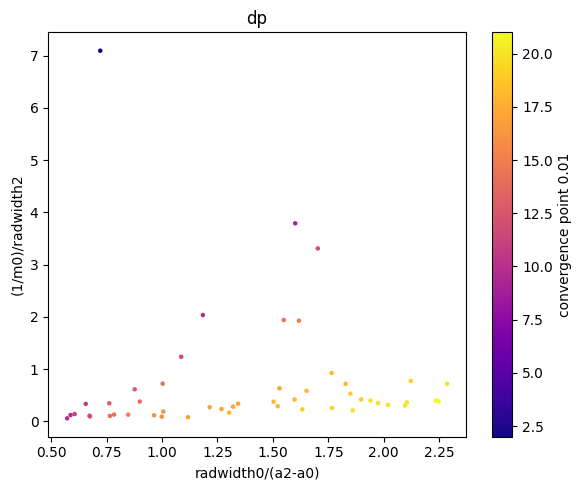

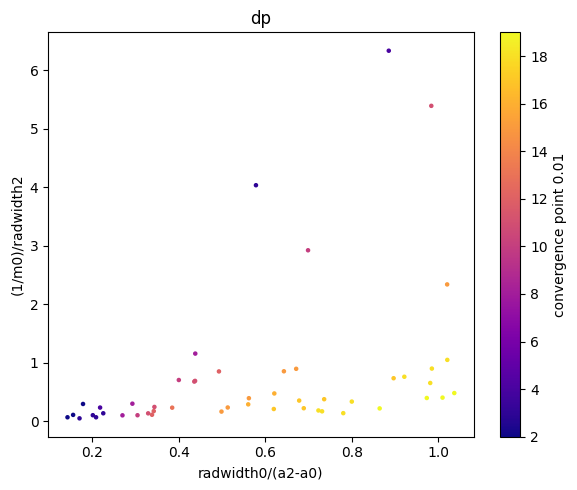

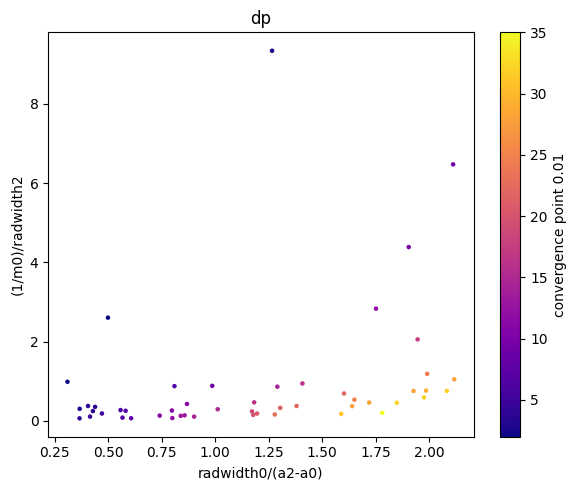

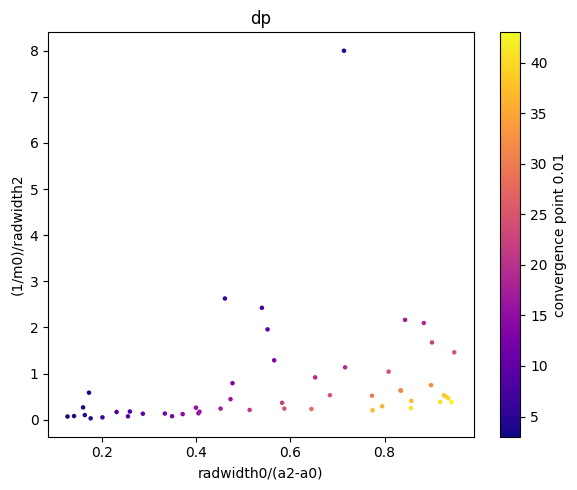

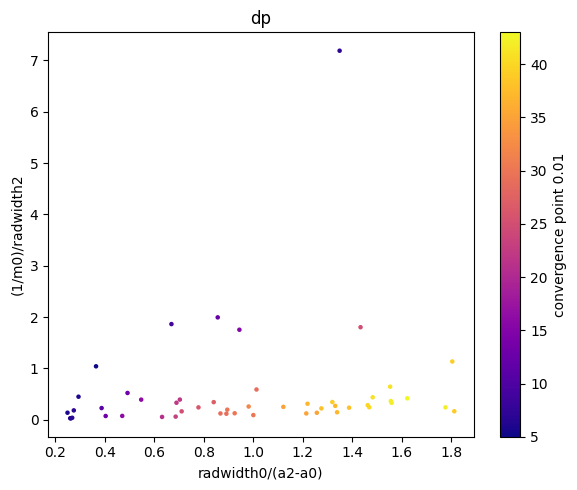

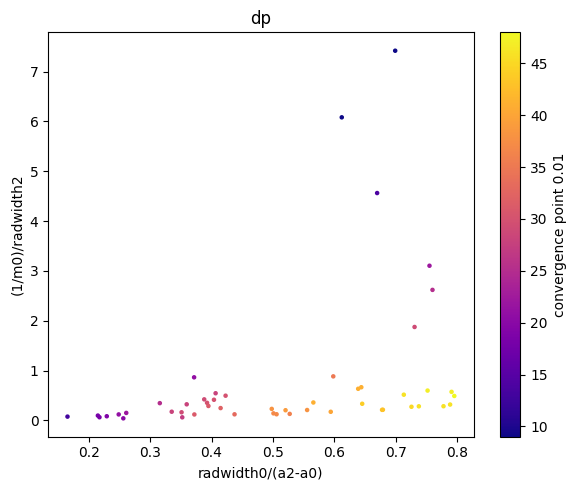

In [ ]:
for prob_set in hist_prob_sets:
  plot_hydros_against_2(prob_set, "dp", 0.01, dim0s["radwidth0/(a2-a0)"], dim0s["(1/m0)/radwidth2"], "radwidth0/(a2-a0)", "(1/m0)/radwidth2")

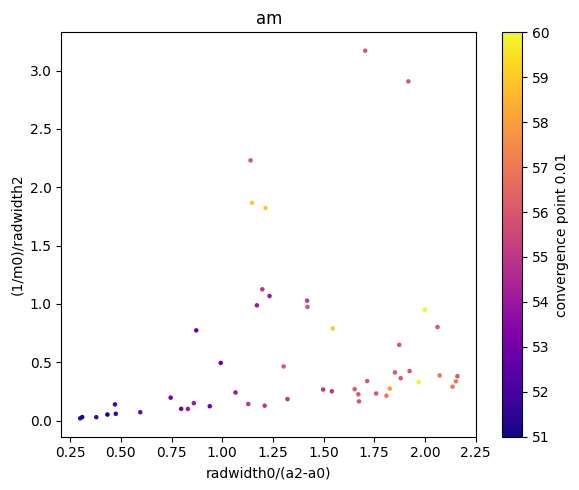

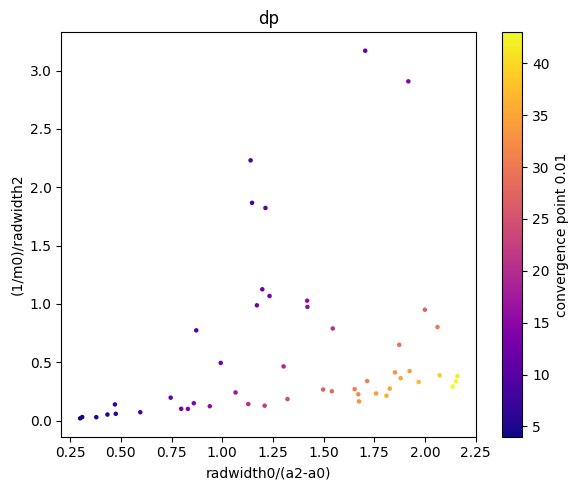

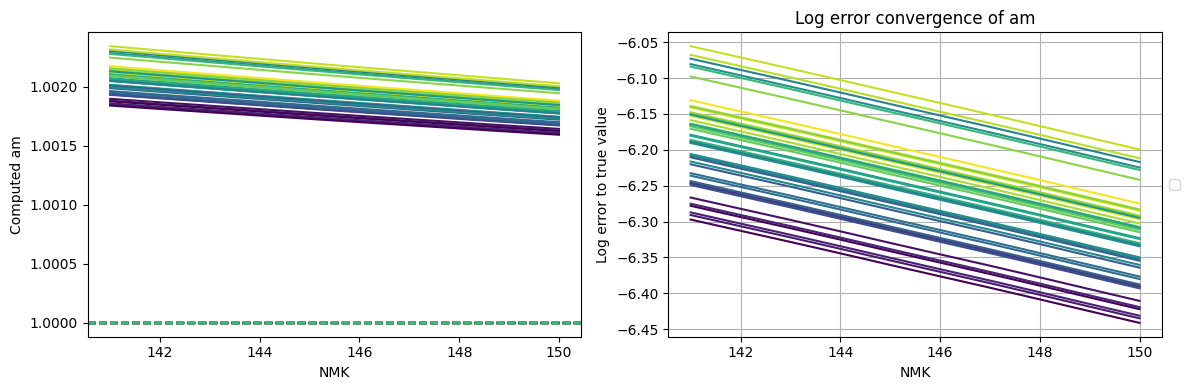

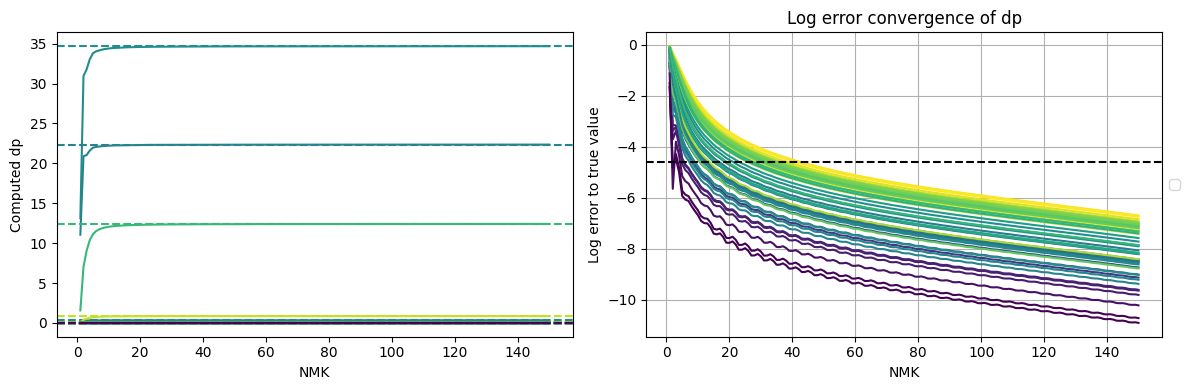

In [38]:
wide_hists = [hist_prob_sets[i] for i in range(32) if i%8>3]
plot_hydros_against_2(suspects, "am", 0.01, dim0s["radwidth0/(a2-a0)"], dim0s["(1/m0)/radwidth2"], "radwidth0/(a2-a0)", "(1/m0)/radwidth2")
plot_hydros_against_2(suspects, "dp", 0.01, dim0s["radwidth0/(a2-a0)"], dim0s["(1/m0)/radwidth2"], "radwidth0/(a2-a0)", "(1/m0)/radwidth2")
data = many_data_dicts_to_convergence_plot_data(suspects)
colors = color_by_f_value(dim0s["radwidth0/(a2-a0)"], suspects)
plot_set_convergence_and_log(data, "am", colors = colors, scale = True, error = 0.01,
                            nmk_max = 150, show_error = False, trunc = 140)
plot_set_convergence_and_log(data, "dp", colors = colors, scale = False, error = 0.01,
                            nmk_max = 150, show_error = True, trunc = 0)

In [ ]:
# hmdrs = [30]
# left_ratios = [0.5, 0.95, 1.05, 1.3]
# right_ratios = [0.5, 0.95, 1.05, 1.3]
# rad_ratios = [0.1, 0.2]

rho, big_nmk, nmk_max = 1023, 200, 150

def solve_and_store(h, d, a, heaving, NMK, m0, rho, nmk_max, region = 1):
  prob = ConvergenceProblemI(h, d, a, heaving, NMK, m0, rho)
  mk = prob.m_k
  info = {"h" : h,
          "d" : d,
          "a" : a,
          "region" : region,
          "m0s" : [m0]}
  print(info)
  return merge_dicts(info, prob.convergence_study_over_m0s(nmk_max, [m0], [mk]))

def generate_h_d_a_m0_three(hmdr, left_ratio, right_ratio, left_rad_ratio, right_rad_ratio, m0_radwidth2):
  while True:
    hmd1 = random.uniform(low = 0, high = 10)
    hmd0 = left_ratio * hmd1
    hmd2 = right_ratio * hmd1
    radwidth1 = hmd1/hmdr
    radwidth0 = radwidth1/left_rad_ratio - radwidth1
    radwidth2 = radwidth0/right_rad_ratio - radwidth1
    m0 = m0_radwidth2/radwidth2
    hmds = [hmd0, hmd1, hmd2]
    h_min = 1.05 * max(hmds)
    if m0 * h_min < 80:
      break
  
  h = random.uniform(low = h_min, high = 80/m0)
  radwidths = [radwidth0, radwidth1, radwidth2]
  d = [h-hmd for hmd in hmds]
  a = [sum(radwidths[0:i+1]) for i in range(len(d))]
  for i in range(len(d)):
    assert d[i] > 0
    inner = 0 if i == 0 else a[i-1]
    assert a[i] > inner
  return h, d, a, m0

hmdr, left_ratio, right_ratio, left_rad_ratio, right_rad_ratio, m0_radwidth2 = 30, 0.5, 1.05, 0.1, 2.1, 0.5

prob_set = []
for i in range(50):
  h, d, a, m0 = generate_h_d_a_m0_three(hmdr, left_ratio, right_ratio, left_rad_ratio, right_rad_ratio, m0_radwidth2)
  prob_set.append(solve_and_store(h, d, a, [0, 1, 0], [big_nmk]*4, m0, rho, nmk_max))

{'h': 84.0170122396752, 'd': [80.53985285279515, 77.06269346591509, 76.71497752722709], 'a': [2.0862956321280315, 2.318106257920035, 3.079769742665189], 'region': 1, 'm0s': [0.6564578846356215]}
{'h': 7.060526719225852, 'd': [4.929366734836645, 2.798206750447438, 2.585090752008517], 'a': [1.278695990633524, 1.420773322926138, 1.8875988433161546], 'region': 1, 'm0s': [1.071063980354517]}
{'h': 23.753942526309622, 'd': [21.95563180636571, 20.157321086421796, 19.977490014427403], 'a': [1.0789864319663482, 1.1988738132959424, 1.5927894948074663], 'region': 1, 'm0s': [1.2693071727467458]}
{'h': 14.209182299740581, 'd': [13.65152351903252, 13.09386473832446, 13.038098860253653], 'a': [0.3345952684248368, 0.37177252047204085, 0.49392634862713997], 'region': 1, 'm0s': [4.093199595555436]}
{'h': 4.3222666383509845, 'd': [3.5882702318741977, 2.854273825397411, 2.7808741847497322], 'a': [0.44039784388607206, 0.4893309376511912, 0.6501111028794397], 'region': 1, 'm0s': [3.1098363364049564]}
{'h': 

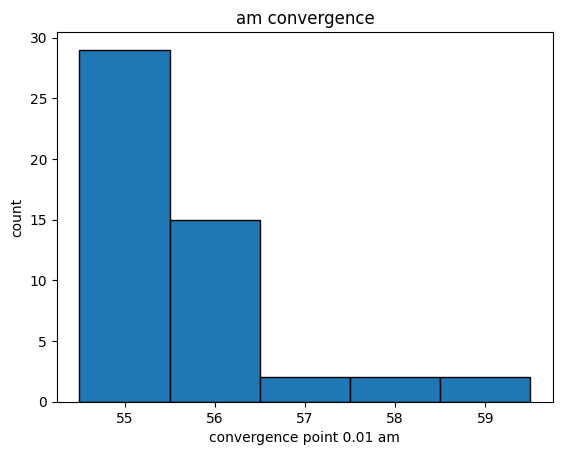

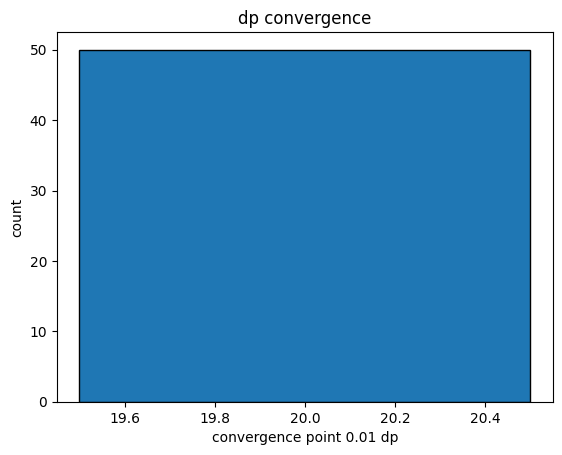

[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20]

In [45]:
generate_convergence_data(prob_set, [0.01, 0.005])
histogram(prob_set, "am", 0.01)
histogram(prob_set, "dp", 0.01)